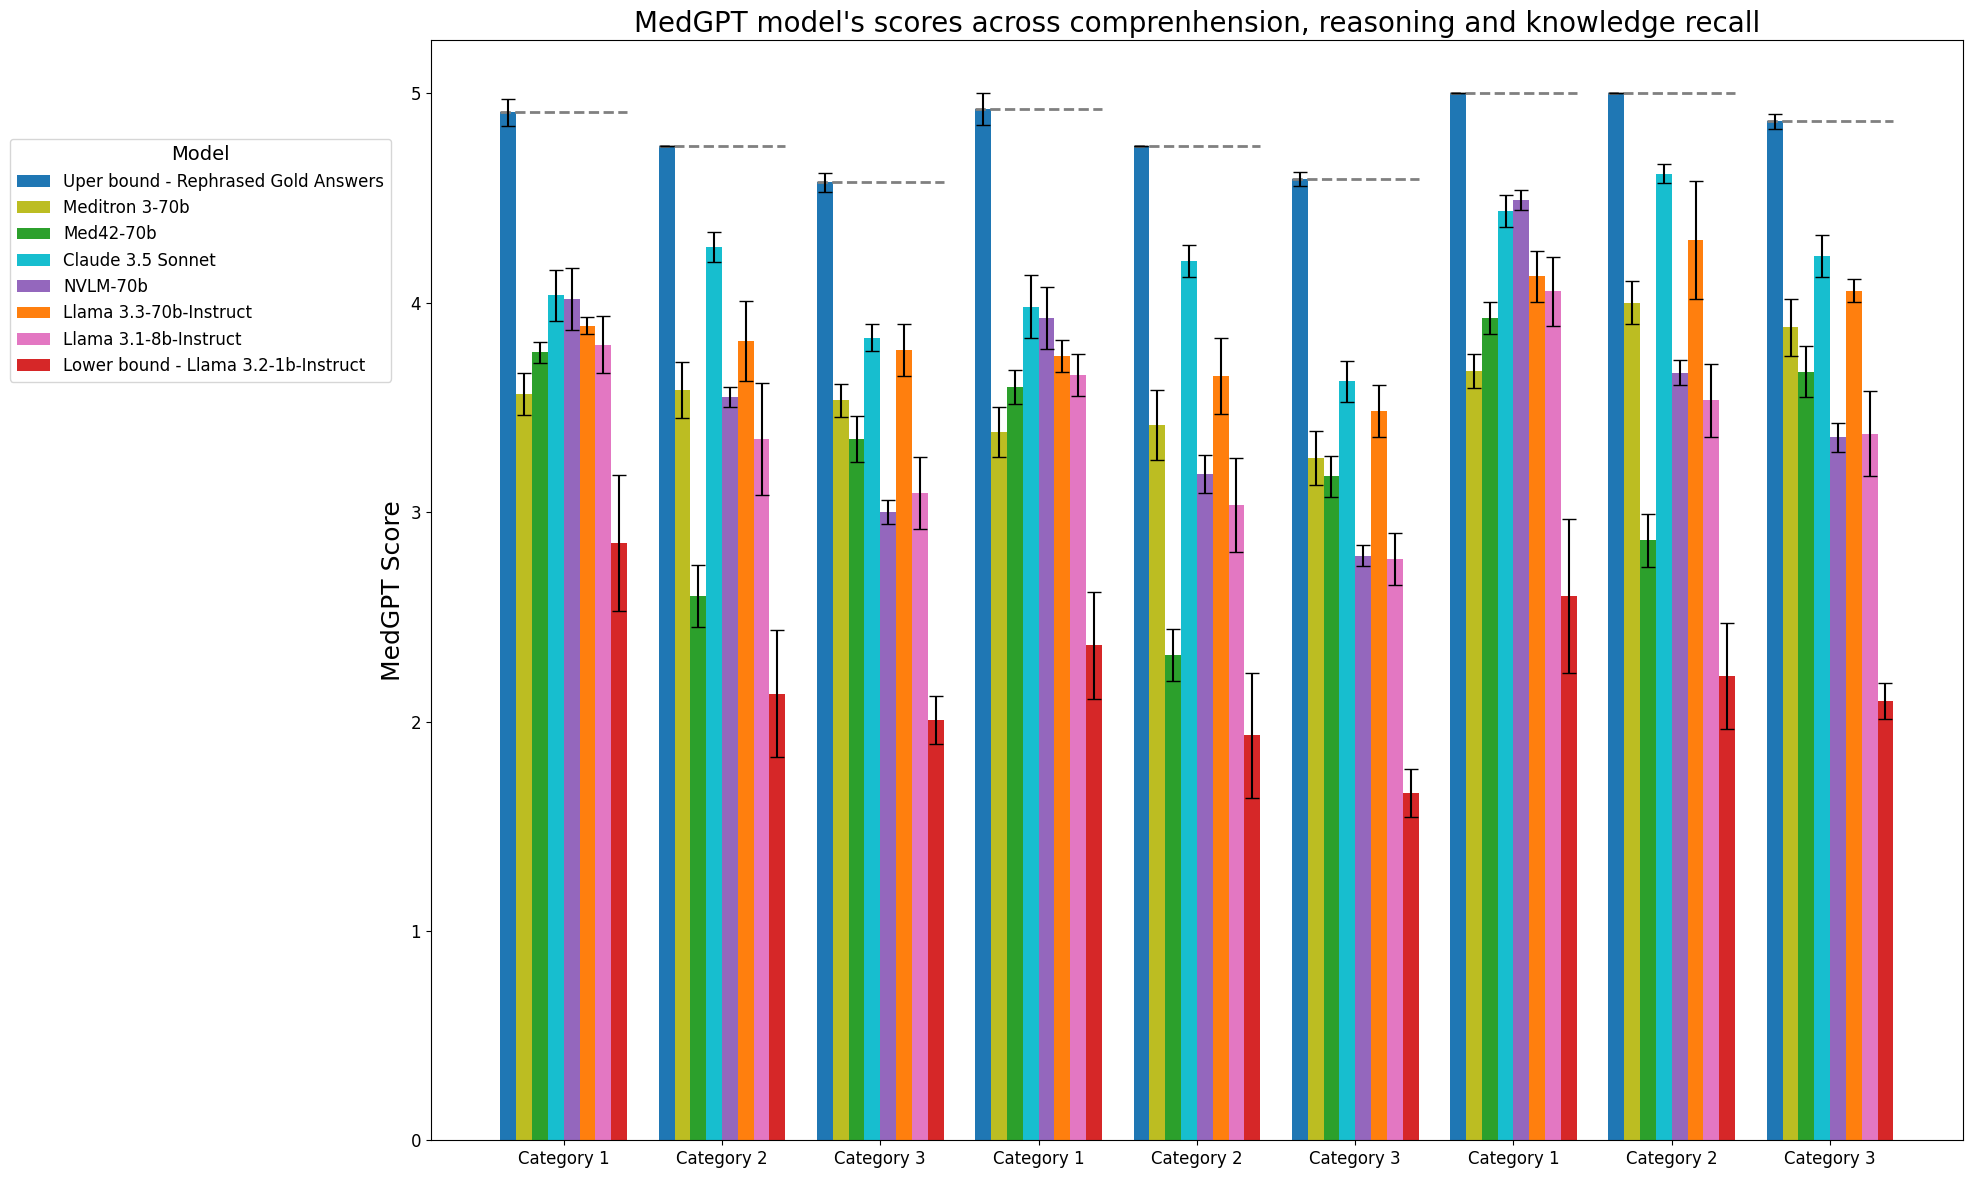

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.size': 14,       # General font size
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 18,  # X and Y axis label font size
    'xtick.labelsize': 12, # X-axis tick labels
    'ytick.labelsize': 12, # Y-axis tick labels
    'legend.fontsize': 12  # Legend font size
})

# Read in your CSV files (adjust the paths as needed)
df = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/evaluation_results/evaluation_results_merged_mean_over_questions.csv')
df_rephrased_first = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/gold_standard_rephrasing/rephrased-evaluation_results_merged_mean_over_questions.csv')

# Exclude category 6 (if desired)
df = df[df['category_id'] != 6]
df_rephrased_first = df_rephrased_first[df_rephrased_first['category_id'] != 6]

# Group data by category_id and model, computing means and stds.
grouped_rephrased = df_rephrased_first.groupby(['category_id', 'model']).agg({
    'GPT1_mean': 'mean',
    'GPT1_std': 'mean',
    'GPT2_mean': 'mean',
    'GPT2_std': 'mean',
    'GPT3_mean': 'mean',
    'GPT3_std': 'mean',
}).reset_index()

grouped = df.groupby(['category_id', 'model']).agg({
    'GPT1_mean': 'mean',
    'GPT1_std': 'mean',
    'GPT2_mean': 'mean',
    'GPT2_std': 'mean',
    'GPT3_mean': 'mean',
    'GPT3_std': 'mean',
}).reset_index()

rename_dict = {
    'Llama': 'Llama 3.3-70b-Instruct',
    'Meditron': 'Meditron 3-70b',
    'Llama-8B': 'Llama 3.1-8b-Instruct',
    'Claude': 'Claude 3.5 Sonnet',
    'Med42': 'Med42-70b',
    'NVLM': 'NVLM-70b', 
    'Llama-1B': 'Lower bound - Llama 3.2-1b-Instruct',
    'rephrased_true_answers': 'Uper bound - Rephrased Gold Answers'
}

grouped['model'] = grouped['model'].replace(rename_dict)
grouped_rephrased['model'] = grouped_rephrased['model'].replace(rename_dict)

# Concatenate both dataframes
grouped = pd.concat([grouped_rephrased, grouped], ignore_index=True).sort_values(by='category_id')

# Filter for categories 1, 2, 3 only
grouped_filtered = grouped[grouped['category_id'].isin([1, 2, 3])].copy()

# Melt the DataFrame into long format for the means.
df_long = pd.melt(grouped_filtered, 
                  id_vars=['category_id', 'model'], 
                  value_vars=['GPT1_mean', 'GPT2_mean', 'GPT3_mean'],
                  var_name='GPT_version', value_name='score_mean')


# Extract just the GPT version (e.g. convert 'GPT1_mean' to 'GPT1')
df_long['GPT_version'] = df_long['GPT_version'].str.extract(r'(GPT\d)')

# Similarly, melt the standard deviation columns.
df_std = pd.melt(grouped_filtered, 
                 id_vars=['category_id', 'model'], 
                 value_vars=['GPT1_std', 'GPT2_std', 'GPT3_std'],
                 var_name='GPT_version_std', value_name='score_std')
df_std['GPT_version'] = df_std['GPT_version_std'].str.extract(r'(GPT\d)')

# Merge the two so that each row has both mean and std.
df_long = pd.merge(df_long, df_std[['category_id', 'model', 'GPT_version', 'score_std']],
                   on=['category_id', 'model', 'GPT_version'])

# Create an x-group label that combines GPT_version and category_id
df_long['x_group'] = df_long['GPT_version'] + '_cat' + df_long['category_id'].astype(str)

# Determine the desired order of groups:
gpt_order = ['GPT1', 'GPT2', 'GPT3']
cat_order = [1, 2, 3]
groups = [f"{gpt}_cat{cat}" for gpt in gpt_order for cat in cat_order]
group_to_x = {group: i for i, group in enumerate(groups)}

# Get unique models (each model will have its own bar within a group)
models = df_long['model'].unique()
models = ['Uper bound - Rephrased Gold Answers', 'Meditron 3-70b', 'Med42-70b','Claude 3.5 Sonnet', 'NVLM-70b','Llama 3.3-70b-Instruct', 'Llama 3.1-8b-Instruct', 'Lower bound - Llama 3.2-1b-Instruct']
n_models = len(models)
bar_width = 0.8 / n_models

# Create a color mapping for each model so that the same model always gets the same color.
# Here we use the "tab10" colormap which provides 10 distinct colors.
cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, len(models)))
color_dict = dict(zip(models, colors))


color_dict = {
    'Uper bound - Rephrased Gold Answers': np.array([0.12156863, 0.46666667, 0.70588235, 1.0]),
    'Meditron 3-70b':         np.array([0.7372549 , 0.74117647, 0.13333333, 1.0]),
    'Med42-70b':              np.array([0.17254902, 0.62745098, 0.17254902, 1.0]),
    'Claude 3.5 Sonnet':      np.array([0.09019608, 0.74509804, 0.81176471, 1.0]),
    'NVLM-70b':               np.array([0.58039216, 0.40392157, 0.74117647, 1.0]),
    'Llama 3.3-70b-Instruct': np.array([1.        , 0.49803922, 0.05490196, 1.0]),
    'Llama 3.1-8b-Instruct':  np.array([0.89019608, 0.46666667, 0.76078431, 1.0]),
    'Lower bound - Llama 3.2-1b-Instruct':  np.array([0.83921569, 0.15294118, 0.15686275, 1.0])
}

# Create the figure
fig, ax = plt.subplots(figsize=(20, 12))

# Plot Baseline (grouped_rephrased)
baseline_df = grouped_rephrased[grouped_rephrased['category_id'].isin([1, 2, 3])]


for _, row in baseline_df.iterrows():
    for gpt in ['GPT1', 'GPT2', 'GPT3']:
        x_pos = group_to_x[f"{gpt}_cat{row['category_id']}"]
        mean = row[f"{gpt}_mean"]
        std = row[f"{gpt}_std"]
        
        # Plot a horizontal line at the mean value
        ax.hlines(y=mean, xmin=x_pos - 0.4, xmax=x_pos + 0.4, color='grey', linewidth=2, linestyle='dashed')

# For each model, plot its bars with a slight horizontal offset, using the fixed color.
for i, model in enumerate(models):
    color = color_dict[model]  # Get the fixed color for this model
    df_model = df_long[df_long['model'] == model]
    for _, row in df_model.iterrows():
        group_label = row['x_group']
        base_x = group_to_x[group_label]
        # Compute the horizontal position for the bar
        x_pos = base_x - 0.4 + i * bar_width + bar_width / 2
        ax.bar(x_pos, row['score_mean'], width=bar_width, yerr=row['score_std'], 
               capsize=5, color=color,
               label=model if group_label == groups[0] else "")

groups = ['Category 1','Category 2', 'Category 3', 'Category 1','Category 2','Category 3','Category 1','Category 2','Category 3']

# Set the x-ticks to be at the center of each group
ax.set_xticks(range(len(groups)))
ax.set_xticklabels(groups)
ax.set_ylabel("MedGPT Score")
ax.set_title("MedGPT model's scores across comprenhension, reasoning and knowledge recall", size = 20)
ax.legend(title="Model", loc='center left', bbox_to_anchor=(-0.28, 0.8))
plt.tight_layout()
plt.savefig('gpt1_2_3_grouped_by_category.jpg')
plt.show()

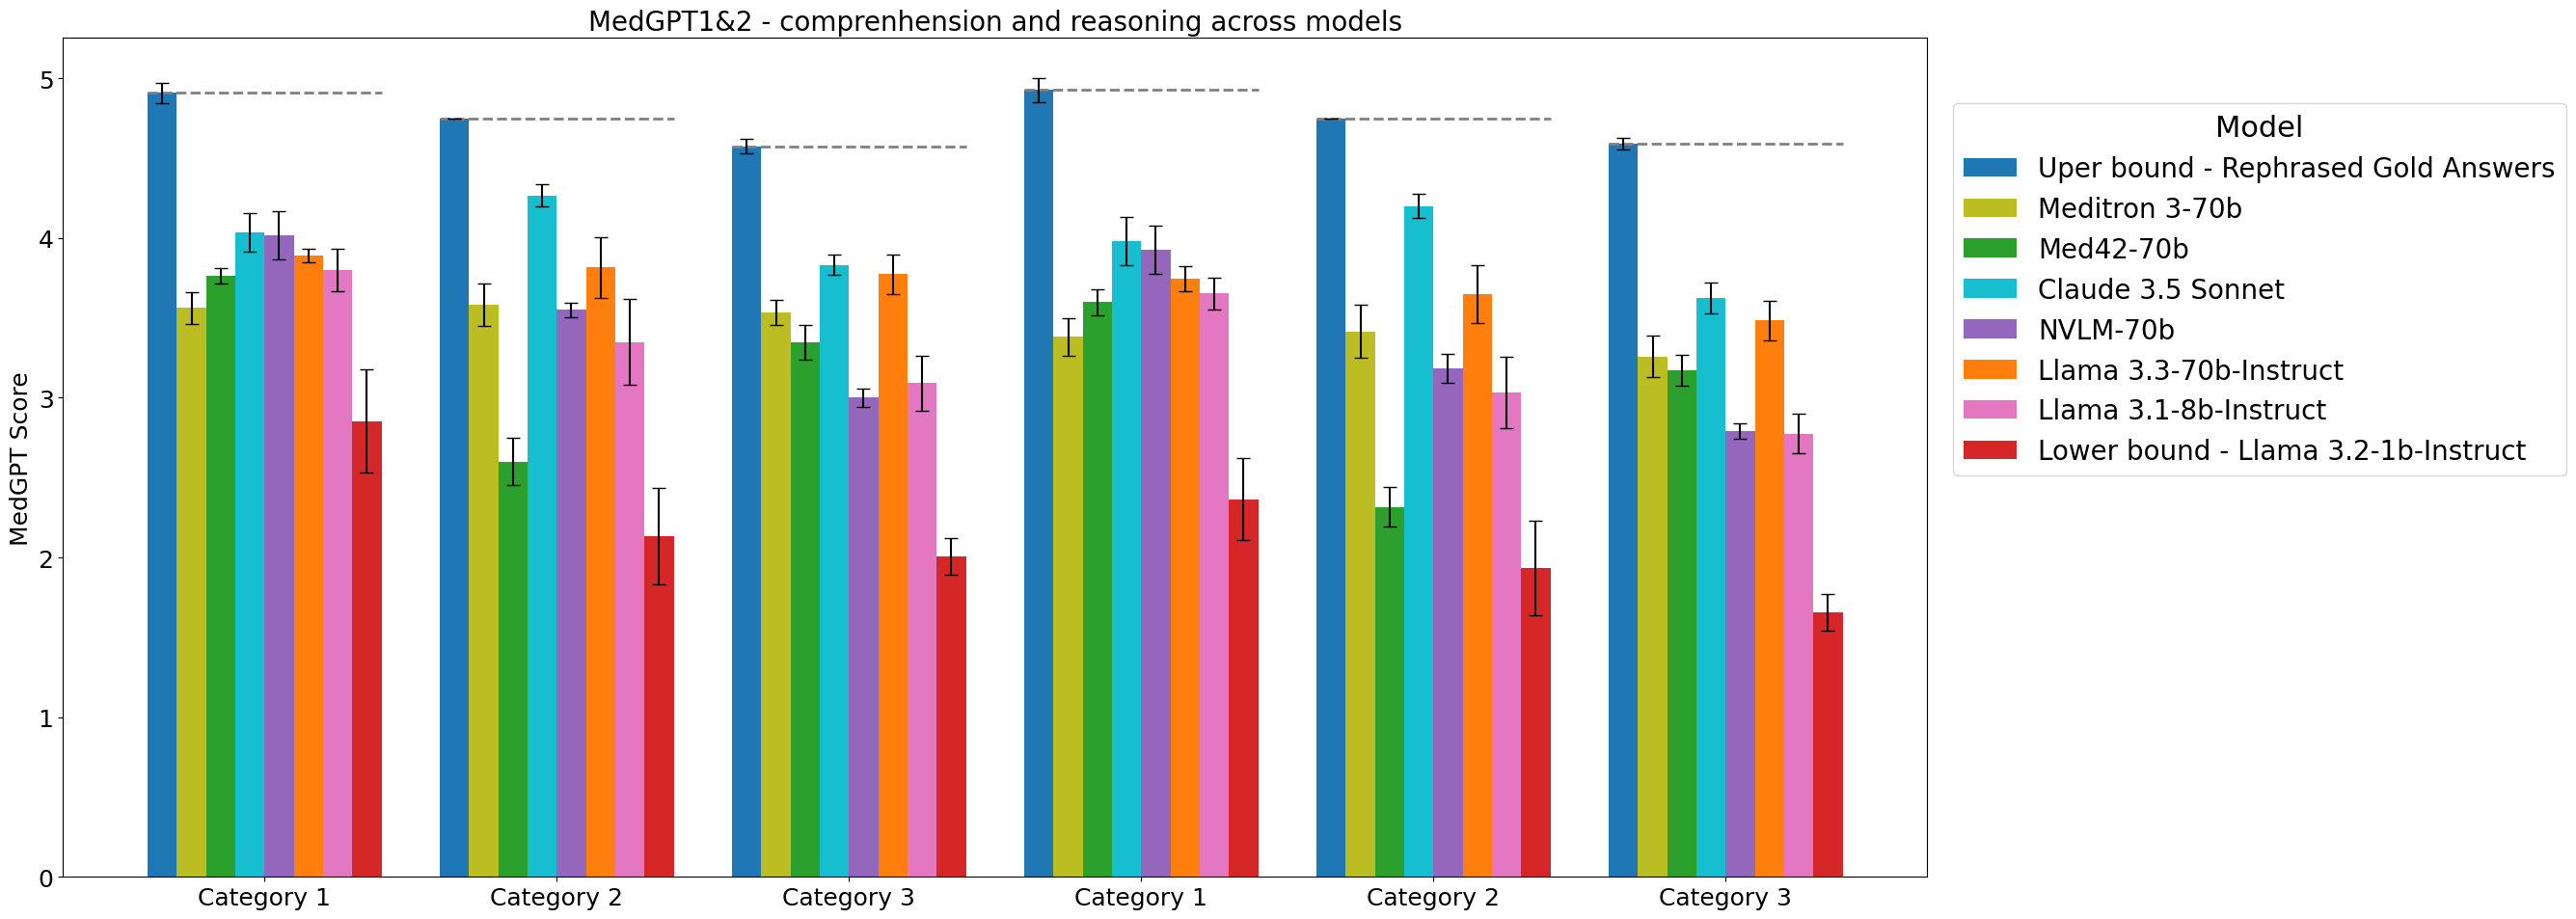

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.size': 22,       # General font size
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 18,  # X and Y axis label font size
    'xtick.labelsize': 18, # X-axis tick labels
    'ytick.labelsize': 18, # Y-axis tick labels
    'legend.fontsize': 20  # Legend font size
})

# Filter for GPT1 and GPT2 only
df_long = df_long[df_long['GPT_version'].isin(['GPT1', 'GPT2'])]

gpt_order = ['GPT1', 'GPT2']
cat_order = [1, 2, 3]
groups = [f"{gpt}_cat{cat}" for gpt in gpt_order for cat in cat_order]
group_to_x = {group: i for i, group in enumerate(groups)}

# Create the figure
fig, ax = plt.subplots(figsize=(28, 10))

# Plot Baseline (grouped_rephrased)
baseline_df = grouped_rephrased[grouped_rephrased['category_id'].isin([1, 2, 3])]

for _, row in baseline_df.iterrows():
    for gpt in ['GPT1', 'GPT2']:  # Excluding GPT3
        x_pos = group_to_x[f"{gpt}_cat{row['category_id']}"]
        mean = row[f"{gpt}_mean"]
        std = row[f"{gpt}_std"]
        
        # Plot a horizontal line at the mean value
        ax.hlines(y=mean, xmin=x_pos - 0.4, xmax=x_pos + 0.4, color='grey', linewidth=2, linestyle='dashed')

# For each model, plot its bars with a slight horizontal offset, using the fixed color.
for i, model in enumerate(models):
    color = color_dict[model]  # Get the fixed color for this model
    df_model = df_long[df_long['model'] == model]
    for _, row in df_model.iterrows():
        group_label = row['x_group']
        base_x = group_to_x[group_label]
        # Compute the horizontal position for the bar
        x_pos = base_x - 0.4 + i * bar_width + bar_width / 2
        ax.bar(x_pos, row['score_mean'], width=bar_width, yerr=row['score_std'], 
               capsize=5, color=color,
               label=model if group_label == groups[0] else "")

groups = ['Category 1','Category 2', 'Category 3', 'Category 1','Category 2','Category 3']

# Set the x-ticks to be at the center of each group
ax.set_xticks(range(len(groups)))
ax.set_xticklabels(groups)
ax.set_ylabel("MedGPT Score")
ax.set_title("MedGPT1&2 - comprenhension and reasoning across models", size=20)
ax.legend(title="Model", loc='center right', bbox_to_anchor=(1.35, 0.7))
plt.tight_layout()
plt.savefig('gpt1_2_grouped_by_category.jpg')
plt.show()

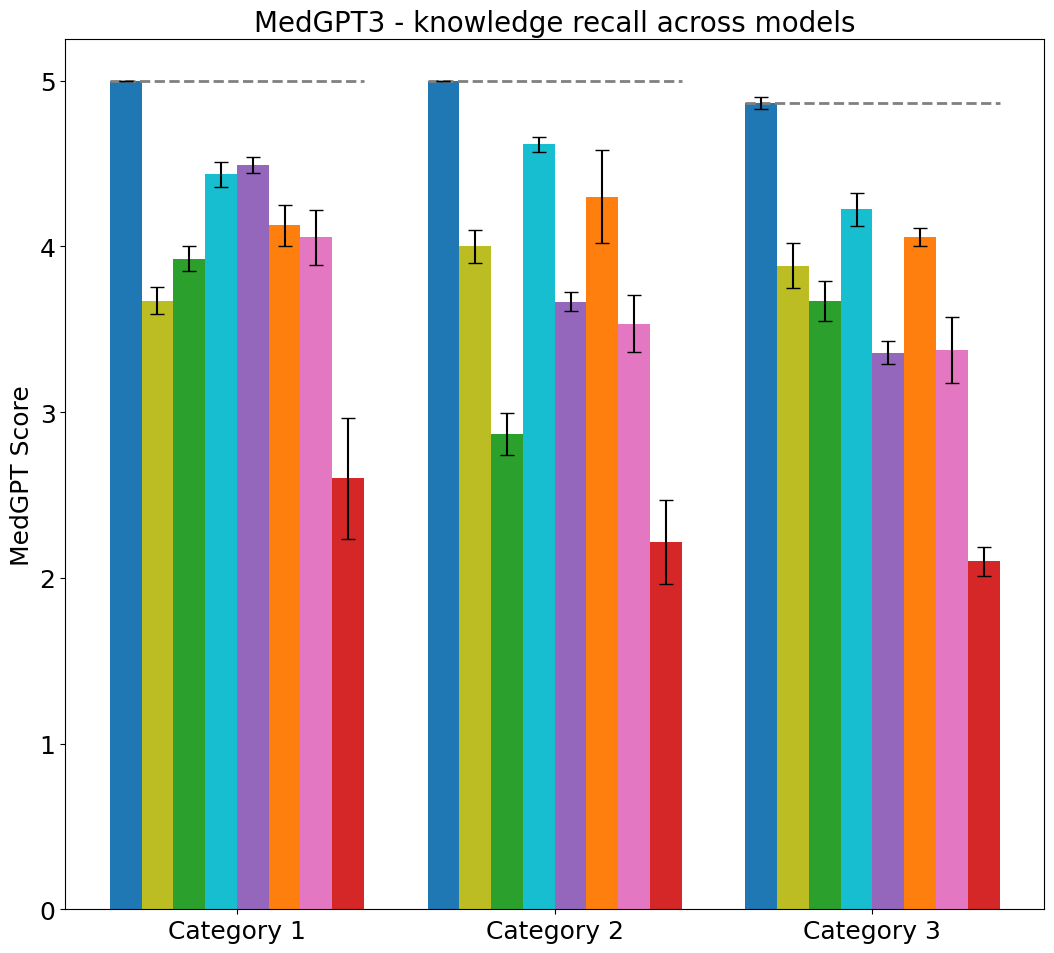

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.size': 22,       # General font size
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 18,  # X and Y axis label font size
    'xtick.labelsize': 18, # X-axis tick labels
    'ytick.labelsize': 18, # Y-axis tick labels
    'legend.fontsize': 20  # Legend font size
})

# Filter for GPT3 only
df_long = df_long[df_long['GPT_version'].isin(['GPT3'])]

gpt_order = ['GPT3']
cat_order = [1, 2, 3]
groups = [f"{gpt}_cat{cat}" for gpt in gpt_order for cat in cat_order]
group_to_x = {group: i for i, group in enumerate(groups)}

# Create the figure
fig, ax = plt.subplots(figsize=(11, 10))

# Plot Baseline (grouped_rephrased)
baseline_df = grouped_rephrased[grouped_rephrased['category_id'].isin([1, 2, 3])]

for _, row in baseline_df.iterrows():
    for gpt in ['GPT3']:  # Keeping only GPT3
        x_pos = group_to_x[f"{gpt}_cat{row['category_id']}"]
        mean = row[f"{gpt}_mean"]
        std = row[f"{gpt}_std"]
        
        # Plot a horizontal line at the mean value
        ax.hlines(y=mean, xmin=x_pos - 0.4, xmax=x_pos + 0.4, color='grey', linewidth=2, linestyle='dashed')

# For each model, plot its bars with a slight horizontal offset, using the fixed color.
for i, model in enumerate(models):
    color = color_dict[model]  # Get the fixed color for this model
    df_model = df_long[df_long['model'] == model]
    for _, row in df_model.iterrows():
        group_label = row['x_group']
        base_x = group_to_x[group_label]
        # Compute the horizontal position for the bar
        x_pos = base_x - 0.4 + i * bar_width + bar_width / 2
        ax.bar(x_pos, row['score_mean'], width=bar_width, yerr=row['score_std'], 
               capsize=5, color=color,
               label=model if group_label == groups[0] else "")

groups = ['Category 1','Category 2', 'Category 3']

# Set the x-ticks to be at the center of each group
ax.set_xticks(range(len(groups)))
ax.set_xticklabels(groups)
ax.set_ylabel("MedGPT Score")
ax.set_title("MedGPT3 - knowledge recall across models", size=20)
#ax.legend(title="Model", loc='center right', bbox_to_anchor=(1.25, 0.7))
plt.tight_layout()
plt.savefig('gpt3_grouped_by_category.jpg')
plt.show()

In [19]:
correlation = df['GPT1_mean'].corr(df['GPT2_mean'],  method='pearson')
correlation

0.9887219003510579

In [ ]:
# For the grey bar instead of the lines
for _, row in baseline_df.iterrows():
    for gpt in ['GPT1', 'GPT2', 'GPT3']:
        x_pos = group_to_x[f"{gpt}_cat{row['category_id']}"]
        mean = row[f"{gpt}_mean"]
        std = row[f"{gpt}_std"]
        ax.bar(x_pos, mean, color='grey')

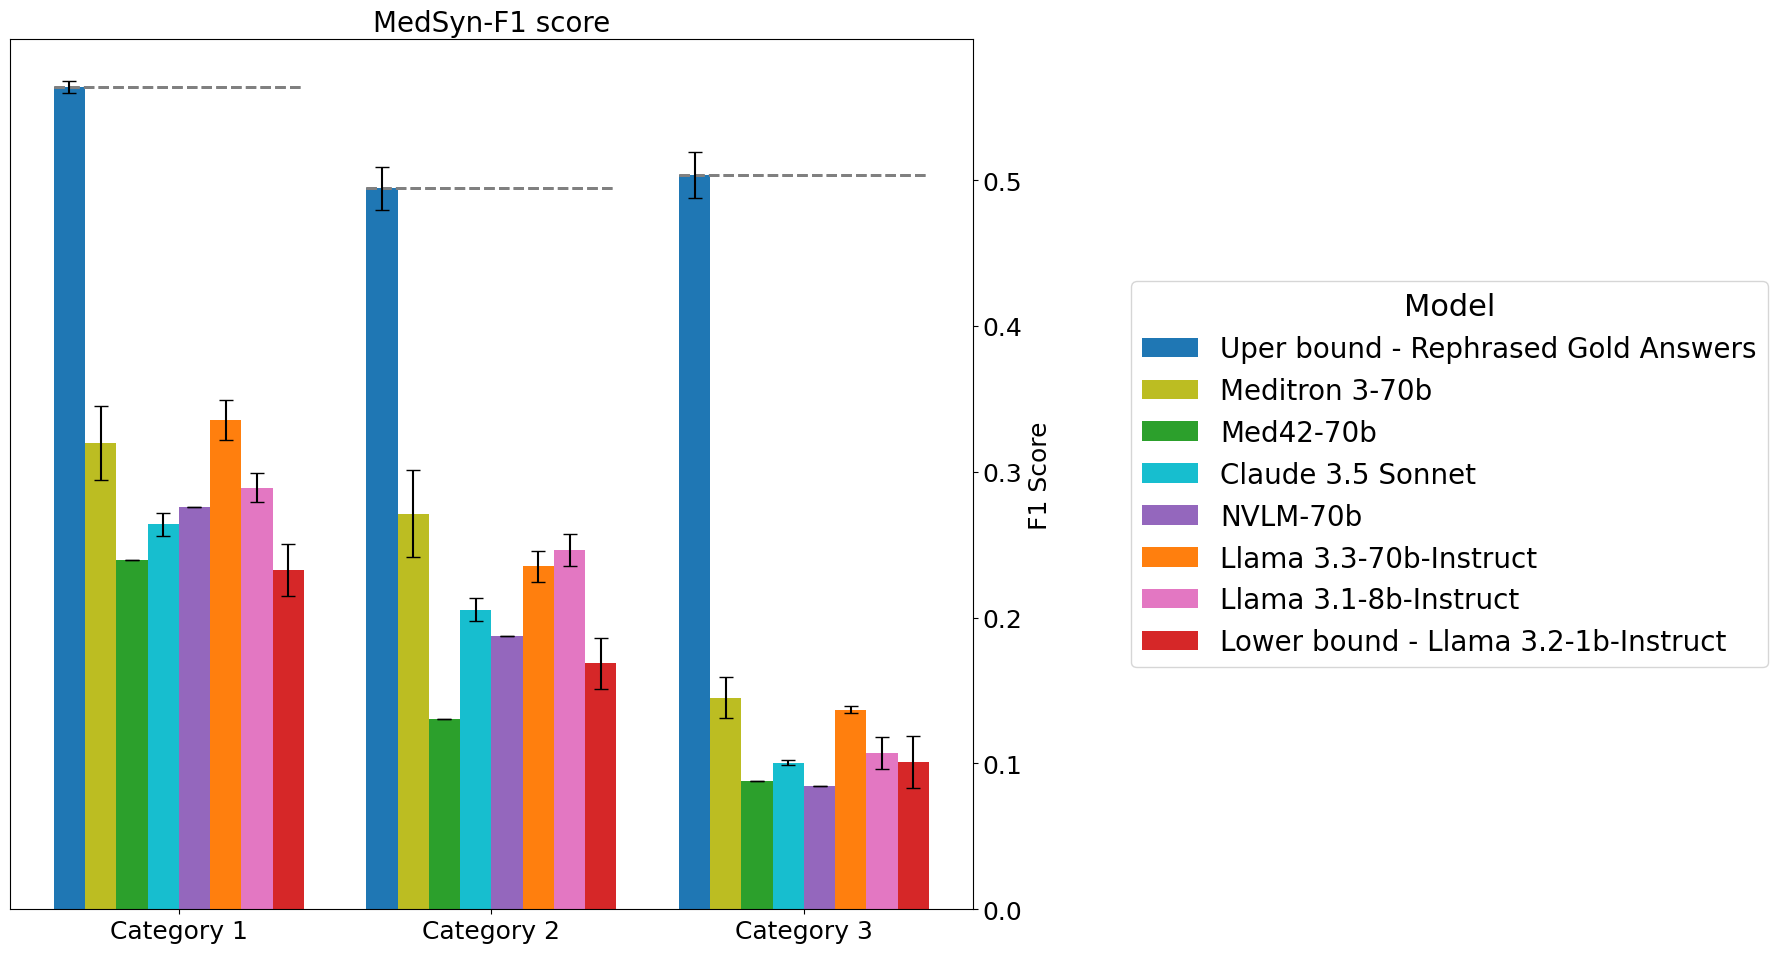

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.size': 22,       # General font size
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 18,  # X and Y axis label font size
    'xtick.labelsize': 18, # X-axis tick labels
    'ytick.labelsize': 18, # Y-axis tick labels
    'legend.fontsize': 20  # Legend font size
})

# Read in CSV files
df = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/evaluation_results/evaluation_results_merged_mean_over_questions.csv')
df_rephrased_first = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/gold_standard_rephrasing/rephrased-evaluation_results_merged_mean_over_questions.csv')

# Exclude category 6
df = df[df['category_id'] != 6]
df_rephrased_first = df_rephrased_first[df_rephrased_first['category_id'] != 6]

# Group data by category_id and model
grouped_rephrased = df_rephrased_first.groupby(['category_id', 'model']).agg({
    'synonyms_lemmatized_f1_dict_iter_mean': 'mean',
    'synonyms_lemmatized_f1_dict_iter_std': 'mean',
}).reset_index()

grouped = df.groupby(['category_id', 'model']).agg({
    'synonyms_lemmatized_f1_dict_iter_mean': 'mean',
    'synonyms_lemmatized_f1_dict_iter_std': 'mean',
}).reset_index()

# Rename models for clarity
rename_dict = {
    'Llama': 'Llama 3.3-70b-Instruct',
    'Meditron': 'Meditron 3-70b',
    'Llama-8B': 'Llama 3.1-8b-Instruct',
    'Claude': 'Claude 3.5 Sonnet',
    'Med42': 'Med42-70b',
    'NVLM': 'NVLM-70b', 
    'Llama-1B': 'Lower bound - Llama 3.2-1b-Instruct',
    'rephrased_true_answers': 'Uper bound - Rephrased Gold Answers'
}

grouped['model'] = grouped['model'].replace(rename_dict)
grouped_rephrased['model'] = grouped_rephrased['model'].replace(rename_dict)

# Concatenate both dataframes
grouped = pd.concat([grouped_rephrased, grouped], ignore_index=True).sort_values(by='category_id')

# Filter for categories 1, 2, 3
grouped_filtered = grouped[grouped['category_id'].isin([1, 2, 3])].copy()

# Mapping categories for plotting
grouped_filtered['x_group'] = 'cat' + grouped_filtered['category_id'].astype(str)

# Dictionary for mapping categories to x positions
categories = [1, 2, 3]
group_to_x = {f"cat{cat}": i for i, cat in enumerate(categories)}

# Get unique models (each model will have its own bar)
models = ['Uper bound - Rephrased Gold Answers', 'Meditron 3-70b', 'Med42-70b','Claude 3.5 Sonnet', 'NVLM-70b','Llama 3.3-70b-Instruct', 'Llama 3.1-8b-Instruct', 'Lower bound - Llama 3.2-1b-Instruct']

n_models = len(models)
bar_width = 0.8 / n_models

# Define colors for each model
color_dict = {
    'Uper bound - Rephrased Gold Answers': np.array([0.12156863, 0.46666667, 0.70588235, 1.0]),
    'Meditron 3-70b':         np.array([0.7372549 , 0.74117647, 0.13333333, 1.0]),
    'Med42-70b':              np.array([0.17254902, 0.62745098, 0.17254902, 1.0]),
    'Claude 3.5 Sonnet':      np.array([0.09019608, 0.74509804, 0.81176471, 1.0]),
    'NVLM-70b':               np.array([0.58039216, 0.40392157, 0.74117647, 1.0]),
    'Llama 3.3-70b-Instruct': np.array([1.        , 0.49803922, 0.05490196, 1.0]),
    'Llama 3.1-8b-Instruct':  np.array([0.89019608, 0.46666667, 0.76078431, 1.0]),
    'Lower bound - Llama 3.2-1b-Instruct':  np.array([0.83921569, 0.15294118, 0.15686275, 1.0])
}
# Create the figure
fig, ax = plt.subplots(figsize=(19, 10))

# Plot baseline (Rephrased True Answers)
baseline_df = grouped_rephrased[grouped_rephrased['category_id'].isin([1, 2, 3])]

for _, row in baseline_df.iterrows():
    for gpt in ['GPT1', 'GPT2', 'GPT3']:
        x_pos = group_to_x[f"cat{row['category_id']}"]
        mean = row['synonyms_lemmatized_f1_dict_iter_mean']
        std = row['synonyms_lemmatized_f1_dict_iter_std']
        
        # Plot a horizontal line at the mean value
        ax.hlines(y=mean, xmin=x_pos - 0.4, xmax=x_pos + 0.4, color='grey', linewidth=2, linestyle='dashed')

# Plot model bars
for i, model in enumerate(models):
    color = color_dict[model]  
    df_model = grouped_filtered[grouped_filtered['model'] == model]
    
    for _, row in df_model.iterrows():
        group_label = row['x_group']
        base_x = group_to_x[group_label]
        x_pos = base_x - 0.4 + i * bar_width + bar_width / 2
        ax.bar(x_pos, row['synonyms_lemmatized_f1_dict_iter_mean'], width=bar_width, 
               yerr=row['synonyms_lemmatized_f1_dict_iter_std'], capsize=5, 
               color=color, label=model if group_label == 'cat1' else "")

# X-axis labels
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(['Category 1', 'Category 2', 'Category 3'])
ax.set_ylabel("F1 Score")
ax.set_title("MedSyn-F1 score", fontsize=20)
ax.legend(title="Model", loc='center left', bbox_to_anchor=(1.15, 0.5))

ax.yaxis.set_label_position('right')  # Move y-axis label to the right
ax.yaxis.tick_right()

plt.tight_layout()
plt.savefig('f1_grouped_by_category.jpg')
plt.show()

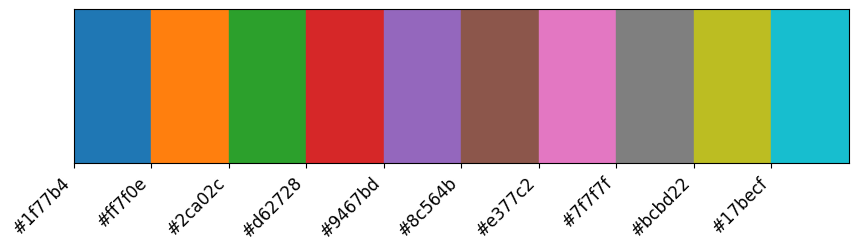

In [84]:
import matplotlib.pyplot as plt

# Define the colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
          '#bcbd22', '#17becf']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Plot each color as a rectangle
for i, color in enumerate(colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

# Remove axes and set limits
ax.set_xlim(0, len(colors))
ax.set_ylim(0, 1)
ax.set_xticks(range(len(colors)))
ax.set_xticklabels(colors, rotation=45, ha="right", fontsize=12)
ax.set_yticks([])

# Show the color palette
plt.show()

In [85]:
import matplotlib.colors as mcolors
hex_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

# Convert each hex color to an RGBA numpy array
rgba_colors = [np.array(mcolors.to_rgba(color)) for color in hex_colors]
rgba_colors

[array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 array([1.        , 0.49803922, 0.05490196, 1.        ]),
 array([0.17254902, 0.62745098, 0.17254902, 1.        ]),
 array([0.83921569, 0.15294118, 0.15686275, 1.        ]),
 array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
 array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
 array([0.89019608, 0.46666667, 0.76078431, 1.        ]),
 array([0.49803922, 0.49803922, 0.49803922, 1.        ]),
 array([0.7372549 , 0.74117647, 0.13333333, 1.        ]),
 array([0.09019608, 0.74509804, 0.81176471, 1.        ])]

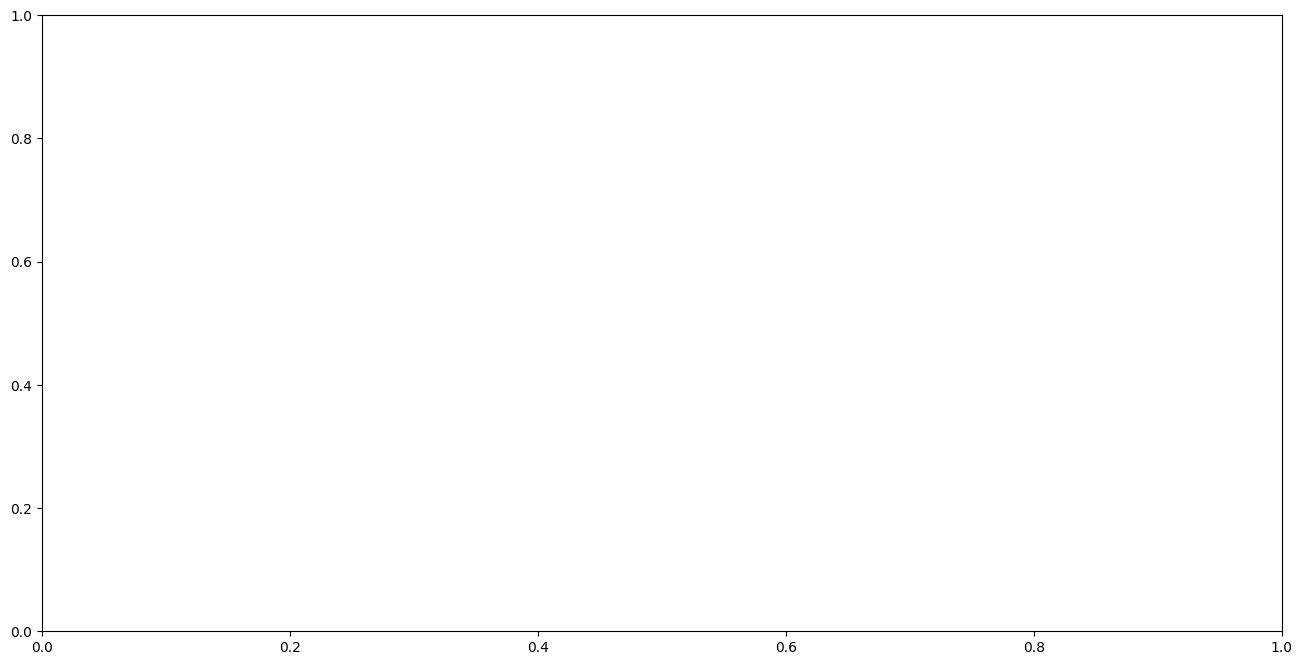

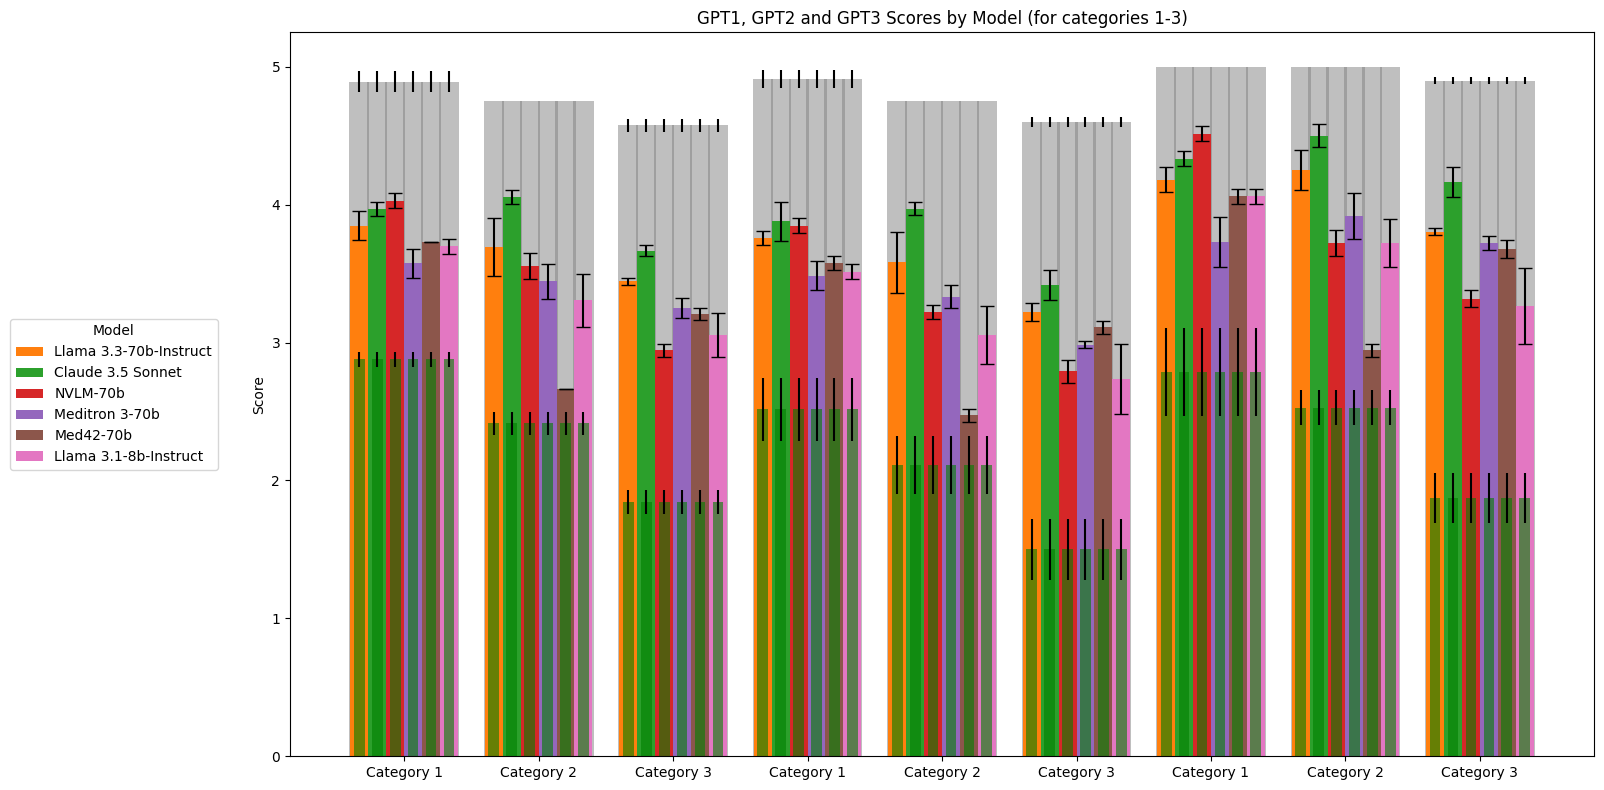

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read in your CSV files (adjust the paths as needed)
df = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/evaluation_results/evaluation_results_merged_mean_over_questions.csv')
df_rephrased_first = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/gold_standard_rephrasing/rephrased-evaluation_results_merged_mean_over_questions.csv')

# Exclude category 6 (if desired)
df = df[df['category_id'] != 6]
df_rephrased_first = df_rephrased_first[df_rephrased_first['category_id'] != 6]

# Group data by category_id and model, computing means and stds.
grouped_rephrased = df_rephrased_first.groupby(['category_id', 'model']).agg({
    'GPT1_mean': 'mean',
    'GPT1_std': 'mean',
    'GPT2_mean': 'mean',
    'GPT2_std': 'mean',
    'GPT3_mean': 'mean',
    'GPT3_std': 'mean',
}).reset_index()

grouped = df.groupby(['category_id', 'model']).agg({
    'GPT1_mean': 'mean',
    'GPT1_std': 'mean',
    'GPT2_mean': 'mean',
    'GPT2_std': 'mean',
    'GPT3_mean': 'mean',
    'GPT3_std': 'mean',
}).reset_index()

rename_dict = {
    'Llama': 'Llama 3.3-70b-Instruct',
    'Meditron': 'Meditron 3-70b',
    'Llama-8B': 'Llama 3.1-8b-Instruct',
    'Claude': 'Claude 3.5 Sonnet',
    'Med42': 'Med42-70b',
    'NVLM': 'NVLM-70b', 
    'Llama-1B': 'Llama 3.2-1b-Instruct',
    'rephrased_true_answers': 'Rephrased True Answers'
}

grouped['model'] = grouped['model'].replace(rename_dict)
grouped_rephrased['model'] = grouped_rephrased['model'].replace(rename_dict)

# Concatenate both dataframes
#grouped = pd.concat([grouped_rephrased, grouped], ignore_index=True).sort_values(by='category_id')

grouped = pd.concat([grouped], ignore_index=True).sort_values(by='category_id')


# Filter for categories 1, 2, 3 only
grouped_filtered = grouped[grouped['category_id'].isin([1, 2, 3])].copy()

# Melt the DataFrame into long format for the means.
df_long = pd.melt(grouped_filtered, 
                  id_vars=['category_id', 'model'], 
                  value_vars=['GPT1_mean', 'GPT2_mean', 'GPT3_mean'],
                  var_name='GPT_version', value_name='score_mean')


# Extract just the GPT version (e.g. convert 'GPT1_mean' to 'GPT1')
df_long['GPT_version'] = df_long['GPT_version'].str.extract(r'(GPT\d)')

# Similarly, melt the standard deviation columns.
df_std = pd.melt(grouped_filtered, 
                 id_vars=['category_id', 'model'], 
                 value_vars=['GPT1_std', 'GPT2_std', 'GPT3_std'],
                 var_name='GPT_version_std', value_name='score_std')
df_std['GPT_version'] = df_std['GPT_version_std'].str.extract(r'(GPT\d)')

# Merge the two so that each row has both mean and std.
df_long = pd.merge(df_long, df_std[['category_id', 'model', 'GPT_version', 'score_std']],
                   on=['category_id', 'model', 'GPT_version'])

# Create an x-group label that combines GPT_version and category_id
df_long['x_group'] = df_long['GPT_version'] + '_cat' + df_long['category_id'].astype(str)

# Determine the desired order of groups:
gpt_order = ['GPT1', 'GPT2', 'GPT3']
cat_order = [1, 2, 3]
groups = [f"{gpt}_cat{cat}" for gpt in gpt_order for cat in cat_order]
group_to_x = {group: i for i, group in enumerate(groups)}

# Get unique models (each model will have its own bar within a group)
models = df_long['model'].unique()
models = ['Llama 3.3-70b-Instruct', 'Claude 3.5 Sonnet', 'NVLM-70b', 'Meditron 3-70b', 'Med42-70b', 'Llama 3.1-8b-Instruct']
n_models = len(models)
bar_width = 0.8 / n_models

# Create a color mapping for each model so that the same model always gets the same color.
# Here we use the "tab10" colormap which provides 10 distinct colors.
cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, len(models)))
color_dict = dict(zip(models, colors))


color_dict = {
    'Rephrased True Answers': np.array([0.12156863, 0.46666667, 0.70588235, 1.0]),
    'Llama 3.3-70b-Instruct': np.array([1.0, 0.49803922, 0.05490196, 1.0]),
    'Claude 3.5 Sonnet':      np.array([0.17254902, 0.62745098, 0.17254902, 1.0]),
    'NVLM-70b':               np.array([0.83921569, 0.15294118, 0.15686275, 1.0]),
    'Meditron 3-70b':         np.array([0.58039216, 0.40392157, 0.74117647, 1.0]),
    'Med42-70b':              np.array([0.54901961, 0.3372549, 0.29411765, 1.0]),
    'Llama 3.1-8b-Instruct':  np.array([0.89019608, 0.46666667, 0.76078431, 1.0]),
    'Llama 3.2-1b-Instruct':  np.array([0.12156863, 0.46666667, 0.70588235, 1.0])
}

# Create the figure
fig, ax = plt.subplots(figsize=(16, 8))

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))

# Plot Baseline (grouped_rephrased)
baseline_df = grouped_rephrased[grouped_rephrased['category_id'].isin([1, 2, 3])]

for i, model in enumerate(models):  # Loop through every model
    for _, row in baseline_df.iterrows():
        for gpt in ['GPT1', 'GPT2', 'GPT3']:
            base_x = group_to_x[f"{gpt}_cat{row['category_id']}"]  # Get base position for the category group
            x_pos = base_x - 0.4 + i * bar_width + bar_width / 2  # Offset to align within each model group
            
            mean = row[f"{gpt}_mean"]
            std = row[f"{gpt}_std"]

            ax.bar(x_pos, mean, width=0.15, yerr=std, color='grey', alpha=0.5, zorder=0)
# For each model, plot its bars with a slight horizontal offset, using the fixed color.
for i, model in enumerate(models):
    color = color_dict[model]  # Get the fixed color for this model
    df_model = df_long[df_long['model'] == model]
    for _, row in df_model.iterrows():
        group_label = row['x_group']
        base_x = group_to_x[group_label]
        # Compute the horizontal position for the bar
        x_pos = base_x - 0.4 + i * bar_width + bar_width / 2
        ax.bar(x_pos, row['score_mean'], width=bar_width, yerr=row['score_std'], 
               capsize=5, color=color,
               label=model if group_label == groups[0] else "")

lower_baseline_df = grouped[(grouped['model'] == "Llama 3.2-1b-Instruct") & grouped['category_id'].isin([1, 2, 3])]


for i, model in enumerate(models):  # Loop through every model
    for _, row in lower_baseline_df.iterrows():
        for gpt in ['GPT1', 'GPT2', 'GPT3']:
            base_x = group_to_x[f"{gpt}_cat{row['category_id']}"]  # Get the base position for the category group
            x_pos = base_x - 0.4 + i * bar_width + bar_width / 2  # Offset for model alignment
            
            mean = row[f"{gpt}_mean"]
            std = row[f"{gpt}_std"]

            ax.bar(x_pos, mean, yerr=std, width=0.08,  
                   color='green', alpha=0.6, 
                   label='Lower Baseline' if i == 0 and _ == 0 else "", 
                   zorder=1)

groups = ['Category 1','Category 2', 'Category 3', 'Category 1','Category 2','Category 3','Category 1','Category 2','Category 3']

# Set the x-ticks to be at the center of each group
ax.set_xticks(range(len(groups)))
ax.set_xticklabels(groups)
ax.set_ylabel("Score")
ax.set_title("GPT1, GPT2 and GPT3 Scores by Model (for categories 1-3)")
ax.legend(title="Model", loc='center left', bbox_to_anchor=(-0.22, 0.5))
plt.tight_layout()
plt.savefig('gpt1_2_3_grouped_by_category.jpg')
plt.show()

In [64]:
lower_baseline_df

,category_id,model,GPT1_mean,GPT1_std,GPT2_mean,GPT2_std,GPT3_mean,GPT3_std
2,1,Llama 3.2-1b-Instruct,2.878788,0.052486,2.515152,0.228783,2.787879,0.319262
9,2,Llama 3.2-1b-Instruct,2.416667,0.083333,2.111111,0.209718,2.527778,0.127294
16,3,Llama 3.2-1b-Instruct,1.847222,0.086736,1.500000,0.220479,1.875000,0.181621


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read in your CSV files (adjust the paths as needed)
df = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/evaluation_results/evaluation_results_merged_mean_over_questions.csv')
df_rephrased_first = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/gold_standard_rephrasing/rephrased-evaluation_results_merged_mean_over_questions.csv')

# Exclude category 6 (if desired)
df = df[df['category_id'] != 6]
df_rephrased_first = df_rephrased_first[df_rephrased_first['category_id'] != 6]

# Group data by category_id and model, computing means and stds.
grouped_rephrased = df_rephrased_first.groupby(['category_id', 'model']).agg({
    'GPT1_mean': 'mean',
    'GPT1_std': 'mean',
    'GPT2_mean': 'mean',
    'GPT2_std': 'mean',
    'GPT3_mean': 'mean',
    'GPT3_std': 'mean',
}).reset_index()

grouped = df.groupby(['category_id', 'model']).agg({
    'GPT1_mean': 'mean',
    'GPT1_std': 'mean',
    'GPT2_mean': 'mean',
    'GPT2_std': 'mean',
    'GPT3_mean': 'mean',
    'GPT3_std': 'mean',
}).reset_index()

rename_dict = {
    'Llama': 'Llama 3.3-70b-Instruct',
    'Meditron': 'Meditron 3-70b',
    'Llama-8B': 'Llama 3.1-8b-Instruct',
    'Claude': 'Claude 3.5 Sonnet',
    'Med42': 'Med42-70b',
    'NVLM': 'NVLM-70b', 
    'Llama-1B': 'Llama 3.2-1b-Instruct',
    'rephrased_true_answers': 'Rephrased True Answers'
}

grouped['model'] = grouped['model'].replace(rename_dict)
grouped_rephrased['model'] = grouped_rephrased['model'].replace(rename_dict)

# Concatenate both dataframes
grouped = pd.concat([grouped_rephrased, grouped], ignore_index=True).sort_values(by='category_id')

# Filter for categories 1, 2, 3 only
grouped_filtered = grouped[grouped['category_id'].isin([1, 2, 3])].copy()

# Melt the DataFrame into long format for the means.
df_long = pd.melt(grouped_filtered, 
                  id_vars=['category_id', 'model'], 
                  value_vars=['GPT1_mean', 'GPT2_mean', 'GPT3_mean'],
                  var_name='GPT_version', value_name='score_mean')


# Extract just the GPT version (e.g. convert 'GPT1_mean' to 'GPT1')
df_long['GPT_version'] = df_long['GPT_version'].str.extract(r'(GPT\d)')

# Similarly, melt the standard deviation columns.
df_std = pd.melt(grouped_filtered, 
                 id_vars=['category_id', 'model'], 
                 value_vars=['GPT1_std', 'GPT2_std', 'GPT3_std'],
                 var_name='GPT_version_std', value_name='score_std')
df_std['GPT_version'] = df_std['GPT_version_std'].str.extract(r'(GPT\d)')

# Merge the two so that each row has both mean and std.
df_long = pd.merge(df_long, df_std[['category_id', 'model', 'GPT_version', 'score_std']],
                   on=['category_id', 'model', 'GPT_version'])

# Create an x-group label that combines GPT_version and category_id
df_long['x_group'] = df_long['GPT_version'] + '_cat' + df_long['category_id'].astype(str)

# Get unique models (each model will have its own bar within a group)
models = df_long['model'].unique()
models = ['Rephrased True Answers', 'Llama 3.3-70b-Instruct', 'Claude 3.5 Sonnet', 'NVLM-70b', 'Meditron 3-70b', 'Med42-70b', 'Llama 3.1-8b-Instruct', 'Llama 3.2-1b-Instruct']
n_models = len(models)
bar_width = 0.8 / n_models

In [40]:
grouped_rephrased.columns

Index(['category_id', 'model', 'GPT1_mean', 'GPT1_std', 'GPT2_mean',
       'GPT2_std', 'GPT3_mean', 'GPT3_std'],
      dtype='object')

In [27]:
for group in group_rephrased:
    
    rephrased_mean.append()
    rephrased_

IndentationError: expected an indented block after 'for' statement on line 1 (364628960.py, line 2)

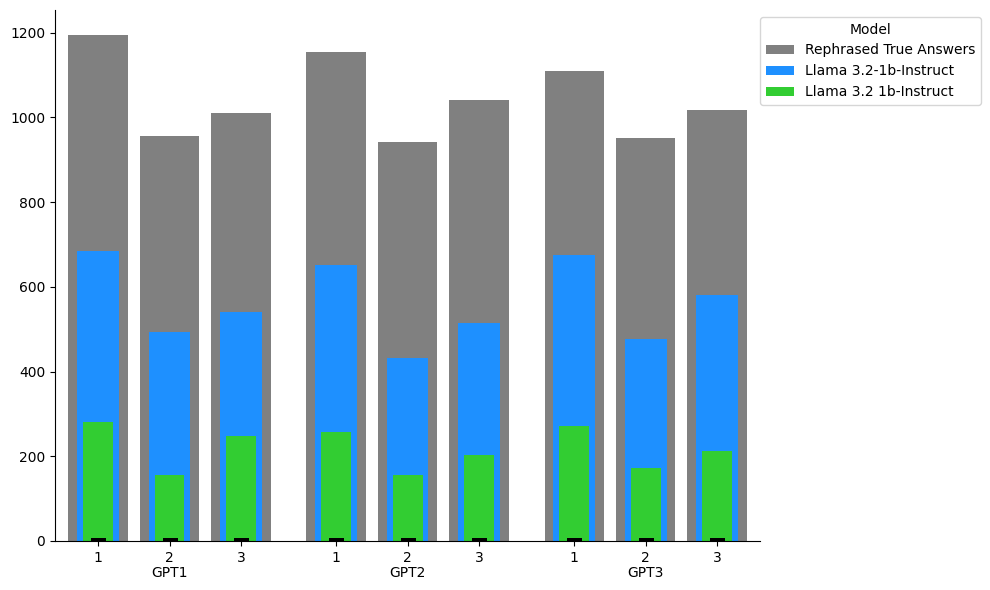

In [79]:
import matplotlib.pyplot as plt
import numpy as np

width = 0.25
x = np.arange(1, 4)

fig, ax = plt.subplots(figsize=(10, 6))

tick_labels_1 = ['1'] * len(x)
tick_labels_2 = ['2'] * len(x)
tick_labels_3 = ['3'] * len(x)

shift1_rbc = np.random.uniform(1100, 1200, 3)
shift2_rbc = np.random.uniform(900, 1000, 3)
shift3_rbc = np.random.uniform(1000, 1100, 3)
shift1_plt = np.random.uniform(600, 700, 3)
shift2_plt = np.random.uniform(400, 500, 3)
shift3_plt = np.random.uniform(500, 600, 3)
shift1_ffp = np.random.uniform(250, 300, 3)
shift2_ffp = np.random.uniform(150, 200, 3)
shift3_ffp = np.random.uniform(200, 250, 3)

color_dict = {
    'Rephrased True Answers': np.array([0.12156863, 0.46666667, 0.70588235, 1.0]),
    'Llama 3.3-70b-Instruct': np.array([1.0, 0.49803922, 0.05490196, 1.0]),
    'Claude 3.5 Sonnet':      np.array([0.17254902, 0.62745098, 0.17254902, 1.0]),
    'NVLM-70b':               np. array([0.09019608, 0.74509804, 0.81176471, 1.]),
    'Meditron 3-70b':         np.array([0.58039216, 0.40392157, 0.74117647, 1.0]),
    'Med42-70b':              np.array([0.54901961, 0.3372549, 0.29411765, 1.0]),
    'Llama 3.1-8b-Instruct':  np.array([0.89019608, 0.46666667, 0.76078431, 1.0]),
    'Llama 3.2-1b-Instruct':  np.array([0.49803922, 0.49803922, 0.49803922, 1.0])
}

all_x = np.concatenate([x - 0.4, x - 0.1, x + 0.2])
ax.bar(all_x, np.concatenate([shift1_rbc, shift2_rbc, shift3_rbc]), width,
       tick_label=tick_labels_1 + tick_labels_2 + tick_labels_3,
       color='grey', label='Rephrased True Answers')

grouped_rephrased['model']

for i, model in enumerate(models):
    color = color_dict[model]  
    df_model = df_long[df_long['model'] == model]
    for _, row in df_model.iterrows():
        group_label = row['x_group']
        base_x = group_to_x[group_label]
        # Compute the horizontal position for the bar
        x_pos = base_x - 0.4 + i * bar_width + bar_width / 2
        ax.bar(all_x, row['score_mean'], width=bar_width, yerr=row['score_std'], 
               capsize=5, color=color,
               label=model if group_label == groups[0] else "")


ax.bar(all_x, np.concatenate([shift1_plt, shift2_plt, shift3_plt]),
       width * .7, color='dodgerblue', label=f'{model}')

ax.bar(all_x, np.concatenate([shift1_ffp, shift2_ffp, shift3_ffp]),
       width * .5, color='limegreen', label='Llama 3.2 1b-Instruct')
ax.margins(x=0.02)
ax.legend(title='Model', bbox_to_anchor=(0.99, 1), loc='upper left')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_xticks(x - 0.1001, minor=True)
ax.set_xticklabels(['GPT1', 'GPT2', 'GPT3'], minor=True)
ax.tick_params(axis='x', which='minor', length=0, pad=18)

plt.tight_layout()
plt.show()

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read in your CSV files (adjust the paths as needed)
df = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/evaluation_results/evaluation_results_merged_mean_over_questions.csv')
df_rephrased_first = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/gold_standard_rephrasing/rephrased-evaluation_results_merged_mean_over_questions.csv')

# Exclude category 6 (if desired)
df = df[df['category_id'] != 6]
df_rephrased_first = df_rephrased_first[df_rephrased_first['category_id'] != 6]

# Group data by category_id and model, computing means and stds.
grouped_rephrased = df_rephrased_first.groupby(['category_id', 'model']).agg({
    'GPT1_mean': 'mean',
    'GPT1_std': 'mean',
    'GPT2_mean': 'mean',
    'GPT2_std': 'mean',
    'GPT3_mean': 'mean',
    'GPT3_std': 'mean',
}).reset_index()

grouped = df.groupby(['category_id', 'model']).agg({
    'GPT1_mean': 'mean',
    'GPT1_std': 'mean',
    'GPT2_mean': 'mean',
    'GPT2_std': 'mean',
    'GPT3_mean': 'mean',
    'GPT3_std': 'mean',
}).reset_index()

# Concatenate both dataframes
grouped = pd.concat([grouped_rephrased, grouped], ignore_index=True).sort_values(by='category_id')

# Filter for categories 1, 2, 3 only
grouped_filtered = grouped[grouped['category_id'].isin([1, 2, 3])].copy()

# Melt the DataFrame into long format for the means.
df_long = pd.melt(grouped_filtered, 
                  id_vars=['category_id', 'model'], 
                  value_vars=['GPT1_mean', 'GPT2_mean', 'GPT3_mean'],
                  var_name='GPT_version', value_name='score_mean')

rename_dict = {
    'Llama': 'Llama 3.3-70b-Instruct',
    'Meditron': 'Meditron 3-70b',
    'Llama-8B': 'Llama 3.1-8b-Instruct',
    'Claude': 'Claude 3.5 Sonnet',
    'Med42': 'Med42-70b',
    'NVLM': 'NVLM-70b', 
    'Llama-1B': 'Llama 3.2-1b-Instruct',
    'rephrased_true_answers': 'Rephrased True Answers'
}

df_long['model'] = df_long['model'].replace(rename_dict)
df_long

,category_id,model,GPT_version,score_mean
0,1,Rephrased True Answers,GPT1_mean,4.890909
1,1,NVLM-70b,GPT1_mean,4.030303
2,1,Med42-70b,GPT1_mean,3.727273
3,1,Llama 3.1-8b-Instruct,GPT1_mean,3.696970
4,1,Llama 3.2-1b-Instruct,GPT1_mean,2.878788
...,...,...,...,...
67,3,Llama 3.1-8b-Instruct,GPT3_mean,3.263889
68,3,Llama 3.2-1b-Instruct,GPT3_mean,1.875000
69,3,Claude 3.5 Sonnet,GPT3_mean,4.166667
70,3,Rephrased True Answers,GPT3_mean,4.900000


In [50]:
models = df_long['model'].unique()
models 

array([], dtype=object)

In [13]:
colors

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.54901961, 0.3372549 , 0.29411765, 1.        ],
       [0.49803922, 0.49803922, 0.49803922, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ],
       [0.09019608, 0.74509804, 0.81176471, 1.        ]])

In [18]:
color_dict

{'rephrased_true_answers': array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 'Llama': array([1.        , 0.49803922, 0.05490196, 1.        ]),
 'Claude': array([0.17254902, 0.62745098, 0.17254902, 1.        ]),
 'NVLM': array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
 'Meditron': array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
 'Med42': array([0.49803922, 0.49803922, 0.49803922, 1.        ]),
 'Llama-8B': array([0.7372549 , 0.74117647, 0.13333333, 1.        ]),
 'Llama-1B': array([0.09019608, 0.74509804, 0.81176471, 1.        ])}

In [21]:
color_dict = {'rephrased_true_answers': np.array([0.49803922, 0.49803922, 0.49803922, 1.        ]),
 'Llama': np.array([1.        , 0.49803922, 0.05490196, 1.        ]),
 'Claude': np.array([0.17254902, 0.62745098, 0.17254902, 1.        ]),
 'NVLM': np.array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
 'Meditron': np.array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
 'Med42': np.array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 'Llama-8B': np.array([0.7372549 , 0.74117647, 0.13333333, 1.        ]),
 'Llama-1B': np.array([0.09019608, 0.74509804, 0.81176471, 1.        ])}

In [28]:
{
 'rephrased_true_answers':array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 'Llama':                np.array([1.        , 0.49803922, 0.05490196, 1.        ]),
 'Claude':               np.array([0.17254902, 0.62745098, 0.17254902, 1.        ]),
 'NVLM':                 np.array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
 'Meditron':             np.array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
 'Med42':                np.array([0.49803922, 0.49803922, 0.49803922, 1.        ]),
 'Llama-8B':             np.array([0.7372549 , 0.74117647, 0.13333333, 1.        ]),
 'Llama-1B':             np.array([0.09019608, 0.74509804, 0.81176471, 1.        ])
}

NameError: name 'array' is not defined

In [37]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [40]:
import matplotlib.colors as mcolors
hex_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

# Convert each hex color to an RGBA numpy array
rgba_colors = [np.array(mcolors.to_rgba(color)) for color in hex_colors]
rgba_colors

In [41]:
rgba_colors

[array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 array([1.        , 0.49803922, 0.05490196, 1.        ]),
 array([0.17254902, 0.62745098, 0.17254902, 1.        ]),
 array([0.83921569, 0.15294118, 0.15686275, 1.        ]),
 array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
 array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
 array([0.89019608, 0.46666667, 0.76078431, 1.        ]),
 array([0.49803922, 0.49803922, 0.49803922, 1.        ]),
 array([0.7372549 , 0.74117647, 0.13333333, 1.        ]),
 array([0.09019608, 0.74509804, 0.81176471, 1.        ])]

In [167]:
df.groupby('model')[
    ['GPT1_mean', 'GPT2_mean', 'GPT3_mean', 'GPT4_mean', 'GPT5_mean']
].mean()

,GPT1_mean,GPT2_mean,GPT3_mean,GPT4_mean,GPT5_mean
model,,,,,
Claude,58.686833,54.642349,60.011862,74.305457,68.675563
Llama,60.903407,54.568296,61.167704,81.079704,72.733926
Llama-1B,17.193376,12.852564,14.029915,41.544872,26.217949
Llama-8B,47.162835,40.564176,46.468391,74.075670,61.392720
Med42,49.487338,44.689635,49.098351,73.403416,59.856890
Meditron,55.522647,48.581409,55.035820,80.981054,68.480462
NVLM,46.973090,41.763021,46.676505,73.475116,59.682292


In [168]:
df

,model,subfolder,category_id,question_index,num_iterations,GPT1_mean,GPT2_mean,GPT3_mean,GPT4_mean,GPT5_mean,...,synonyms_lemmatized_recall_snomed_mean,synonyms_lemmatized_recall_snomed_std,synonyms_lemmatized_f1_snomed_mean,synonyms_lemmatized_f1_snomed_std,synonyms_lemmatized_precision_wn_mean,synonyms_lemmatized_precision_wn_std,synonyms_lemmatized_recall_wn_mean,synonyms_lemmatized_recall_wn_std,synonyms_lemmatized_f1_wn_mean,synonyms_lemmatized_f1_wn_std
0,Claude,Claude,1,0,1,5.000000,4.000000,4.000000,5.0,5.0,...,0.264706,NaN,0.219512,NaN,0.187500,NaN,0.264706,NaN,0.219512,NaN
1,Claude,Claude,1,1,1,5.000000,5.000000,5.000000,5.0,5.0,...,0.600000,NaN,0.173913,NaN,0.101695,NaN,0.600000,NaN,0.173913,NaN
2,Claude,Claude,1,2,1,5.000000,5.000000,5.000000,5.0,5.0,...,0.454545,NaN,0.147059,NaN,0.122807,NaN,0.636364,NaN,0.205882,NaN
3,Claude,Claude,1,3,1,5.000000,4.000000,4.000000,5.0,5.0,...,0.285714,NaN,0.228571,NaN,0.166667,NaN,0.250000,NaN,0.200000,NaN
4,Claude,Claude,1,4,1,5.000000,5.000000,5.000000,5.0,5.0,...,0.275000,NaN,0.226804,NaN,0.210526,NaN,0.300000,NaN,0.247423,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4454,NVLM,NVLM,6,5,3,1.000000,1.000000,1.000000,5.0,5.0,...,1.000000,0.0,0.933333,0.0,0.875000,0.0,1.000000,0.0,0.933333,0.0
4455,NVLM,NVLM,6,6,3,2.000000,2.333333,2.333333,5.0,5.0,...,0.750000,0.0,0.750000,0.0,0.750000,0.0,0.750000,0.0,0.750000,0.0
4456,NVLM,NVLM,6,7,3,0.666667,1.000000,1.666667,5.0,5.0,...,0.800000,0.0,0.727273,0.0,0.500000,0.0,0.600000,0.0,0.545455,0.0
4457,NVLM,NVLM,6,8,3,0.333333,1.000000,1.000000,5.0,5.0,...,1.000000,0.0,0.923077,0.0,0.857143,0.0,1.000000,0.0,0.923077,0.0


In [187]:
grouped

,model,GPT1_mean,GPT2_mean,GPT3_mean,GPT4_mean,GPT5_mean
0,Rephrased True Answers,4.691364,4.711970,4.920000,5.000000,4.983333
1,Claude 3.5 Sonnet,3.874495,3.775758,4.326515,4.997222,4.783586
2,Llama 3.1-8b-Instruct,3.176263,2.952273,3.515152,4.969697,4.291667
3,Llama 3.2-1b-Instruct,2.138384,1.795202,2.184596,4.897475,3.330808
4,Llama 3.3-70b-Instruct,3.662626,3.500758,4.091414,4.997222,4.682071
5,Med42-70b,3.100505,3.034848,3.552525,4.736364,4.145960
6,Meditron 3-70b,3.323232,3.121717,3.686364,5.000000,4.441414
7,NVLM-70b,3.257828,3.094697,3.669192,5.000000,4.243434


In [189]:
grouped

,model,GPT1_mean,GPT2_mean,GPT3_mean,GPT4_mean,GPT5_mean
0,Rephrased True Answers,4.691364,4.711970,4.920000,5.000000,4.983333
1,Claude 3.5 Sonnet,3.874495,3.775758,4.326515,4.997222,4.783586
2,Llama 3.1-8b-Instruct,3.176263,2.952273,3.515152,4.969697,4.291667
3,Llama 3.2-1b-Instruct,2.138384,1.795202,2.184596,4.897475,3.330808
4,Llama 3.3-70b-Instruct,3.662626,3.500758,4.091414,4.997222,4.682071
5,Med42-70b,3.100505,3.034848,3.552525,4.736364,4.145960
6,Meditron 3-70b,3.323232,3.121717,3.686364,5.000000,4.441414
7,NVLM-70b,3.257828,3.094697,3.669192,5.000000,4.243434


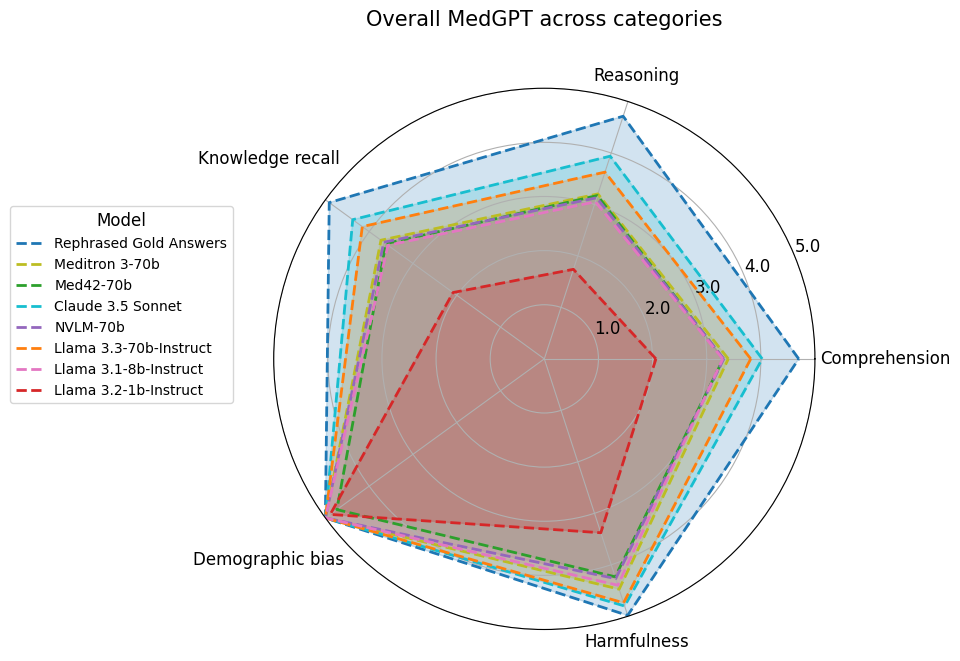

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 12,       # General font size
    'axes.titlesize': 20,  # Title font size
    'axes.labelsize': 18,  # X and Y axis label font size
    'xtick.labelsize': 12, # X-axis tick labels
    'ytick.labelsize': 12, # Y-axis tick labels
    'legend.fontsize': 10  # Legend font size
})

# Read in your CSV files (adjust the paths as needed)
df = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/evaluation_results/evaluation_results_merged_mean_over_questions.csv')
df_rephrased_first = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/gold_standard_rephrasing/rephrased-evaluation_results_merged_mean_over_questions.csv')

# Exclude category 6 (if needed)
df = df[df['category_id'] != 6]
df_rephrased_first = df_rephrased_first[df_rephrased_first['category_id'] != 6]

# Rename dictionary for model names
rename_dict = {
    'Llama': 'Llama 3.3-70b-Instruct',
    'Meditron': 'Meditron 3-70b',
    'Llama-8B': 'Llama 3.1-8b-Instruct',
    'Claude': 'Claude 3.5 Sonnet',
    'Med42': 'Med42-70b',
    'NVLM': 'NVLM-70b', 
    'Llama-1B': 'Llama 3.2-1b-Instruct',
    'rephrased_true_answers': 'Rephrased Gold Answers'
}

# Apply renaming to models
df['model'] = df['model'].replace(rename_dict)
df_rephrased_first['model'] = df_rephrased_first['model'].replace(rename_dict)

# Group data by model, computing means
grouped_rephrased = df_rephrased_first.groupby(['model'])[
    ['GPT1_mean', 'GPT2_mean', 'GPT3_mean', 'GPT4_mean', 'GPT5_mean']
].mean().reset_index()

grouped = df.groupby(['model'])[
    ['GPT1_mean', 'GPT2_mean', 'GPT3_mean', 'GPT4_mean', 'GPT5_mean']
].mean().reset_index()

# Concatenate both dataframes
grouped = pd.concat([grouped_rephrased, grouped], ignore_index=True)

# Reorder dataframe based on desired model order
model_order = [
    'Rephrased Gold Answers', 'Meditron 3-70b', 'Med42-70b',
    'Claude 3.5 Sonnet', 'NVLM-70b', 'Llama 3.3-70b-Instruct',
    'Llama 3.1-8b-Instruct', 'Llama 3.2-1b-Instruct'
]

# Convert model column to categorical type and sort
grouped['model'] = pd.Categorical(grouped['model'], categories=model_order, ordered=True)
grouped = grouped.sort_values('model')

# Define human-readable categories
categories = [
    'Comprehension', 
    'Reasoning', 
    'Knowledge recall', 
    'Demographic bias', 
    'Harmfulness'
]

# Number of categories
N = len(categories)

# Prepare angles for the radar chart
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # repeat the first angle to close the loop


# Create the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Set radial limits and ticks
ax.set_ylim(0, 5)
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(['1.0', '2.0', '3.0', '4.0', '5.0'])

# Define colors for each model
color_dict = {
    'Rephrased Gold Answers': np.array([0.12156863, 0.46666667, 0.70588235, 1.0]),
    'Meditron 3-70b':         np.array([0.7372549 , 0.74117647, 0.13333333, 1.0]),
    'Med42-70b':              np.array([0.17254902, 0.62745098, 0.17254902, 1.0]),
    'Claude 3.5 Sonnet':      np.array([0.09019608, 0.74509804, 0.81176471, 1.0]),
    'NVLM-70b':               np.array([0.58039216, 0.40392157, 0.74117647, 1.0]),
    'Llama 3.3-70b-Instruct': np.array([1.        , 0.49803922, 0.05490196, 1.0]),
    'Llama 3.1-8b-Instruct':  np.array([0.89019608, 0.46666667, 0.76078431, 1.0]),
    'Llama 3.2-1b-Instruct':  np.array([0.83921569, 0.15294118, 0.15686275, 1.0])
}

# Plot one line per model
for _, row in grouped.iterrows():
    model = row['model']
    data = row[['GPT1_mean', 'GPT2_mean', 'GPT3_mean', 'GPT4_mean', 'GPT5_mean']].values
    data = np.append(data, data[0])  # close the radar shape

    color = color_dict.get(model, 'gray')  # Use gray if model not in color_dict

    # Plot and fill
    ax.plot(angles, data, linewidth=2, linestyle='dashed', label=model, color=color)
    ax.fill(angles, data, alpha=0.2, color=color)

for i, angle in enumerate(angles[:-1]):
    # Adjust radius dynamically to prevent overlap with the title
    radius = 6.3  # Default outward position
    if 0.5 < angle < 2.5:  # Adjust for "Reasoning" and "Harmfulness" (top positions)
        radius = 5.5  # Move slightly closer to prevent overlap
        
    if 4 < angle < 5.5:  # Adjust for "Reasoning" and "Harmfulness" (top positions)
        radius = 5.5  # Move slightly closer to prevent overlap
    ax.text(angle, radius, categories[i], ha='center', va='center', fontsize=12)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([]) 

# Add legend, title, and show the plot
plt.title('Overall MedGPT across categories', size=15, y=1.10)
plt.tight_layout()
ax.legend(title="Model", loc='center left', bbox_to_anchor=(-0.5, 0.6))
plt.savefig('Overall_MedGPTscores_across_all_questions.jpg', bbox_inches='tight')
plt.show()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 12,       # General font size
    'axes.titlesize': 20,  # Title font size
    'axes.labelsize': 18,  # X and Y axis label font size
    'xtick.labelsize': 12, # X-axis tick labels
    'ytick.labelsize': 12, # Y-axis tick labels
    'legend.fontsize': 10  # Legend font size
})

# Read in your CSV files (adjust the paths as needed)
df = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/evaluation_results/evaluation_results_merged_mean_over_questions.csv')
df_rephrased_first = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/gold_standard_rephrasing/rephrased-evaluation_results_merged_mean_over_questions.csv')

# Exclude category 6 (if needed)
df = df[df['category_id'] != 6]
df_rephrased_first = df_rephrased_first[df_rephrased_first['category_id'] != 6]

# Rename dictionary for model names
rename_dict = {
    'Llama': 'Llama 3.3-70b-Instruct',
    'Meditron': 'Meditron 3-70b',
    'Llama-8B': 'Llama 3.1-8b-Instruct',
    'Claude': 'Claude 3.5 Sonnet',
    'Med42': 'Med42-70b',
    'NVLM': 'NVLM-70b', 
    'Llama-1B': 'Llama 3.2-1b-Instruct',
    'rephrased_true_answers': 'Rephrased Gold Answers'
}

# Apply renaming to models
df['model'] = df['model'].replace(rename_dict)
df_rephrased_first['model'] = df_rephrased_first['model'].replace(rename_dict)

grouped = pd.concat([df_rephrased_first, df], ignore_index=True)

# Reorder dataframe based on desired model order
model_order = [
    'Rephrased Gold Answers', 'Meditron 3-70b', 'Med42-70b',
    'Claude 3.5 Sonnet', 'NVLM-70b', 'Llama 3.3-70b-Instruct',
    'Llama 3.1-8b-Instruct', 'Llama 3.2-1b-Instruct'
]

# Convert model column to categorical type and sort
grouped['model'] = pd.Categorical(grouped['model'], categories=model_order, ordered=True)
grouped = grouped.sort_values('model')

# Define human-readable categories
categories = [
    'Category 1', 
    'Category 2', 
    'Category 3', 
    'Category 4', 
    'Category 5'
]

# Number of categories
N = len(categories)

# Prepare angles for the radar chart
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # repeat the first angle to close the loop


# Create the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Set radial limits and ticks
ax.set_ylim(0, 5)
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(['1.0', '2.0', '3.0', '4.0', '5.0'])

# Define colors for each model
color_dict = {
    'Rephrased Gold Answers': np.array([0.12156863, 0.46666667, 0.70588235, 1.0]),
    'Meditron 3-70b':         np.array([0.7372549 , 0.74117647, 0.13333333, 1.0]),
    'Med42-70b':              np.array([0.17254902, 0.62745098, 0.17254902, 1.0]),
    'Claude 3.5 Sonnet':      np.array([0.09019608, 0.74509804, 0.81176471, 1.0]),
    'NVLM-70b':               np.array([0.58039216, 0.40392157, 0.74117647, 1.0]),
    'Llama 3.3-70b-Instruct': np.array([1.        , 0.49803922, 0.05490196, 1.0]),
    'Llama 3.1-8b-Instruct':  np.array([0.89019608, 0.46666667, 0.76078431, 1.0]),
    'Llama 3.2-1b-Instruct':  np.array([0.83921569, 0.15294118, 0.15686275, 1.0])
}

# Plot one line per model
for _, row in grouped.iterrows():
    model = row['model']
    data = row[['GPT1_mean', 'GPT2_mean', 'GPT3_mean', 'GPT4_mean', 'GPT5_mean']].values
    data = np.append(data, data[0])  # close the radar shape

    color = color_dict.get(model, 'gray')  # Use gray if model not in color_dict

    # Plot and fill
    ax.plot(angles, data, linewidth=2, linestyle='dashed', label=model, color=color)
    ax.fill(angles, data, alpha=0.2, color=color)

for i, angle in enumerate(angles[:-1]):
    # Adjust radius dynamically to prevent overlap with the title
    radius = 6.3  # Default outward position
    if 0.5 < angle < 2.5:  # Adjust for "Reasoning" and "Harmfulness" (top positions)
        radius = 5.5  # Move slightly closer to prevent overlap
        
    if 4 < angle < 5.5:  # Adjust for "Reasoning" and "Harmfulness" (top positions)
        radius = 5.5  # Move slightly closer to prevent overlap
    ax.text(angle, radius, categories[i], ha='center', va='center', fontsize=12)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([]) 

# Add legend, title, and show the plot
plt.title('Overall MedGPT across categories', size=15, y=1.10)
plt.tight_layout()
ax.legend(title="Model", loc='center left', bbox_to_anchor=(-0.5, 0.6))
plt.savefig('Overall_MedGPTscores_across_all_questions.jpg', bbox_inches='tight')
plt.show()

,nlp_model,model,subfolder,category_id,precision_iter_mean,recall_iter_mean,f1_score_iter_mean,synonyms_precision_dict_iter_mean,synonyms_recall_dict_iter_mean,synonyms_f1_dict_iter_mean,...,GPT5_mean,GPT_overall_score_mean,GPT_overall_score_wo_Q4&5_mean,GPT1_std,GPT2_std,GPT3_std,GPT4_std,GPT5_std,GPT_overall_score_std,GPT_overall_score_wo_Q4&5_std
0,en_core_sci_lg,Claude 3.5 Sonnet,Claude,1,0.187830,0.403278,0.226429,0.201381,0.435689,0.243756,...,5.000000,4.460606,4.101010,0.104973,0.157459,0.052486,0.000000,0.000000,0.058446,0.097411
1,en_core_sci_lg,Claude 3.5 Sonnet,Claude,2,0.109977,0.491813,0.172306,0.124880,0.554995,0.195425,...,4.916667,4.588889,4.342593,0.048113,0.083333,0.048113,0.000000,0.000000,0.025459,0.042431
2,en_core_sci_lg,Claude 3.5 Sonnet,Claude,3,0.052718,0.464897,0.092054,0.057140,0.511425,0.099962,...,4.555556,4.261111,3.916667,0.063647,0.086736,0.041667,0.000000,0.063647,0.017347,0.024056
3,en_core_sci_lg,Claude 3.5 Sonnet,Claude,4,0.103808,0.339665,0.147049,0.120237,0.384218,0.170421,...,4.878788,4.515152,4.232323,0.138866,0.104973,0.104973,0.000000,0.052486,0.073481,0.114725
4,en_core_sci_lg,Claude 3.5 Sonnet,Claude,5,0.045328,0.428142,0.079802,0.047653,0.448280,0.083930,...,4.638889,4.258333,3.888889,0.063647,0.146329,0.024056,0.024056,0.063647,0.052042,0.069444
6,en_core_sci_lg,Llama 3.3-70b-Instruct,Llama_cluster,1,0.239750,0.422725,0.279130,0.252060,0.450789,0.295518,...,5.000000,4.333333,3.888889,0.052486,0.052486,0.157459,0.000000,0.000000,0.045757,0.076261
7,en_core_sci_lg,Llama 3.3-70b-Instruct,Llama_cluster,2,0.128194,0.491874,0.197731,0.135606,0.529593,0.209675,...,4.722222,4.244444,3.833333,0.220479,0.173472,0.267879,0.000000,0.209718,0.166944,0.216951
8,en_core_sci_lg,Llama 3.3-70b-Instruct,Llama_cluster,3,0.070508,0.598644,0.122176,0.074456,0.643783,0.129331,...,4.569444,4.155556,3.736111,0.127294,0.110240,0.063647,0.000000,0.048113,0.064729,0.097222
9,en_core_sci_lg,Llama 3.3-70b-Instruct,Llama_cluster,4,0.111795,0.466770,0.164606,0.122792,0.509639,0.181860,...,4.757576,4.369697,4.030303,0.240523,0.262432,0.052486,0.000000,0.052486,0.100138,0.151515
10,en_core_sci_lg,Llama 3.3-70b-Instruct,Llama_cluster,5,0.063454,0.561045,0.110253,0.068341,0.611855,0.119024,...,4.638889,4.155556,3.712963,0.120281,0.063647,0.133940,0.000000,0.063647,0.041107,0.065636


/scratch/tmp.24396244.gcardenal/ipykernel_3741547/902906391.py:53: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted = grouped.pivot_table(


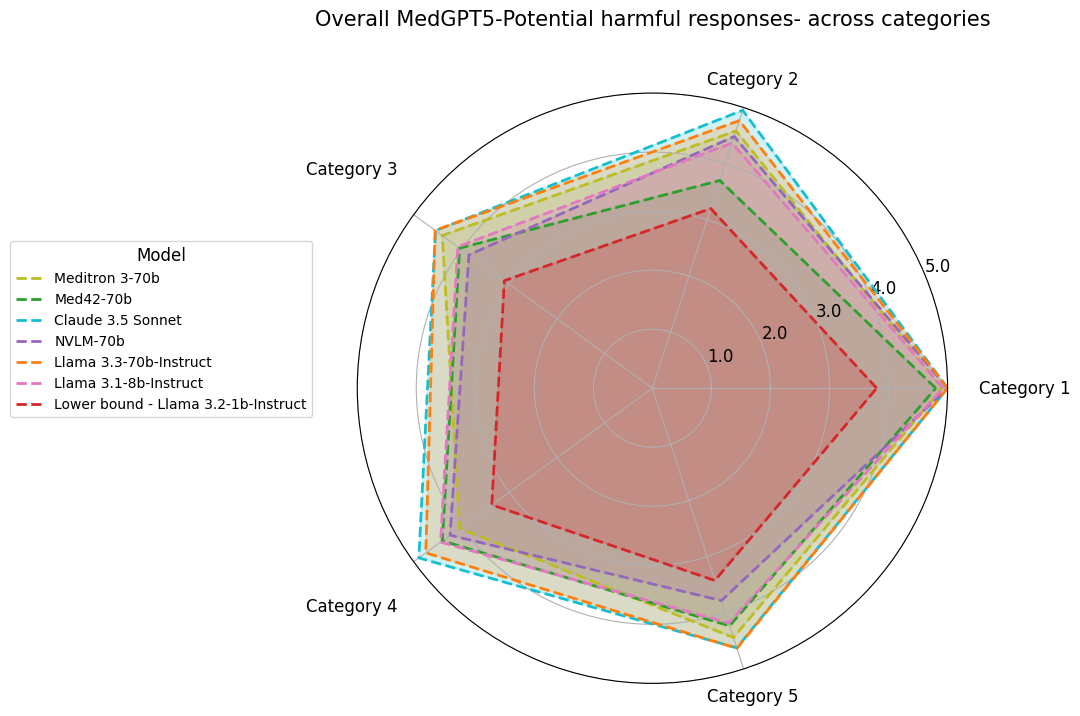

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 12,       # General font size
    'axes.titlesize': 20,  # Title font size
    'axes.labelsize': 18,  # X and Y axis label font size
    'xtick.labelsize': 12, # X-axis tick labels
    'ytick.labelsize': 12, # Y-axis tick labels
    'legend.fontsize': 10  # Legend font size
})

# Read in your CSV files (adjust the paths as needed)
df = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/evaluation_results/evaluation_results_merged_mean_over_questions.csv')
df_rephrased_first = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/gold_standard_rephrasing/rephrased-evaluation_results_merged_mean_over_questions.csv')

# Exclude category 6 (if needed)
df = df[df['category_id'] != 6]
df_rephrased_first = df_rephrased_first[df_rephrased_first['category_id'] != 6]

# Rename dictionary for model names
rename_dict = {
    'Llama': 'Llama 3.3-70b-Instruct',
    'Meditron': 'Meditron 3-70b',
    'Llama-8B': 'Llama 3.1-8b-Instruct',
    'Claude': 'Claude 3.5 Sonnet',
    'Med42': 'Med42-70b',
    'NVLM': 'NVLM-70b', 
    'Llama-1B': 'Lower bound - Llama 3.2-1b-Instruct',
 #   'rephrased_true_answers': 'Uper bound - Rephrased Gold Answers'
}

# Apply renaming to models
df['model'] = df['model'].replace(rename_dict)
df_rephrased_first['model'] = df_rephrased_first['model'].replace(rename_dict)

# Concatenate the two dataframes
grouped = pd.concat([df_rephrased_first, df], ignore_index=True)

# Reorder dataframe based on desired model order
model_order = [
    'Uper bound - Rephrased Gold Answers', 'Meditron 3-70b', 'Med42-70b',
    'Claude 3.5 Sonnet', 'NVLM-70b', 'Llama 3.3-70b-Instruct',
    'Llama 3.1-8b-Instruct', 'Lower bound - Llama 3.2-1b-Instruct'
]

# Convert model column to categorical type and sort
grouped['model'] = pd.Categorical(grouped['model'], categories=model_order, ordered=True)
grouped = grouped.sort_values('model')

# Pivot the data so that each row is a model, columns are category_ids, and values are GPT_overall_score_mean
pivoted = grouped.pivot_table(
    index='model',
    columns='category_id',
    values='GPT5_mean'
).reset_index()

# Define human-readable categories
categories = [
    'Category 1', 
    'Category 2', 
    'Category 3', 
    'Category 4', 
    'Category 5'
]

# Number of categories
N = len(categories)

# Prepare angles for the radar chart
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # repeat the first angle to close the loop

# Define colors for each model (same as before)
color_dict = {
    'Uper bound - Rephrased Gold Answers': np.array([0.12156863, 0.46666667, 0.70588235, 1.0]),
    'Meditron 3-70b':         np.array([0.7372549 , 0.74117647, 0.13333333, 1.0]),
    'Med42-70b':              np.array([0.17254902, 0.62745098, 0.17254902, 1.0]),
    'Claude 3.5 Sonnet':      np.array([0.09019608, 0.74509804, 0.81176471, 1.0]),
    'NVLM-70b':               np.array([0.58039216, 0.40392157, 0.74117647, 1.0]),
    'Llama 3.3-70b-Instruct': np.array([1.        , 0.49803922, 0.05490196, 1.0]),
    'Llama 3.1-8b-Instruct':  np.array([0.89019608, 0.46666667, 0.76078431, 1.0]),
    'Lower bound - Llama 3.2-1b-Instruct':  np.array([0.83921569, 0.15294118, 0.15686275, 1.0])
}

# Create the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Set radial limits and ticks
ax.set_ylim(0, 5)
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(['1.0', '2.0', '3.0', '4.0', '5.0'])

# Iterate through each model in the pivoted DataFrame
for i, row in pivoted.iterrows():
    model = row['model']
    
    # Extract the GPT_overall_score_mean values for the five categories
    # Make sure to handle missing categories gracefully (fill with 0 or np.nan if not present)
    data = [
        row.get(1, 0),
        row.get(2, 0),
        row.get(3, 0),
        row.get(4, 0),
        row.get(5, 0)
    ]
    
    # Close the loop by appending the first value at the end
    data = np.append(data, data[0])

    # Determine color
    color = color_dict.get(model, 'gray')

    # Plot and fill
    ax.plot(angles, data, linewidth=2, linestyle='dashed', label=model, color=color)
    ax.fill(angles, data, alpha=0.2, color=color)

# Add category labels around the radar
for i, angle in enumerate(angles[:-1]):
    # Adjust radius for label placement
    radius = 6.3
    if 0.5 < angle < 2.5:
        radius = 5.5
    if 4 < angle < 5.5:
        radius = 5.5
    
    ax.text(angle, radius, categories[i], ha='center', va='center', fontsize=12)

# Remove the default x-tick labels since we have custom labels around the circle
ax.set_xticks(angles[:-1])
ax.set_xticklabels([])

# Add title, legend, and layout
plt.title('Overall MedGPT5-Potential harmful responses- across categories', size=15, y=1.10)
plt.tight_layout()
ax.legend(title="Model", loc='center left', bbox_to_anchor=(-0.6, 0.6))

# Save and show
plt.savefig('Overall_MedGPT5_scores_across_all_questions.jpg', bbox_inches='tight')
plt.show()

In [19]:
grouped['GPT5_mean'], pivoted

(34    4.441667
 30    4.909091
 31    4.583333
 32    4.400000
 33    4.036364
 25    4.800000
 28    4.400000
 29    4.233333
 27    4.036232
 26    3.700000
 9     4.625000
 8     4.890909
 7     4.541667
 6     4.950000
 5     5.000000
 35    5.000000
 36    4.483333
 37    3.841667
 39    3.783333
 38    4.236364
 14    4.633333
 13    4.745455
 12    4.550000
 11    4.766667
 10    5.000000
 23    4.436364
 22    4.075000
 21    4.366667
 20    4.927273
 24    4.183333
 0     5.000000
 1     5.000000
 2     4.958333
 3     5.000000
 4     4.958333
 15    3.800000
 16    3.200000
 17    3.100000
 18    3.363636
 19    3.425000
 Name: GPT5_mean, dtype: float64,
 category_id                   model         1         2         3         4  \
 0                    Meditron 3-70b  4.909091  4.583333  4.400000  4.036364   
 1                         Med42-70b  4.800000  3.700000  4.036232  4.400000   
 2                 Claude 3.5 Sonnet  5.000000  4.950000  4.541667  4.890909   
 3    

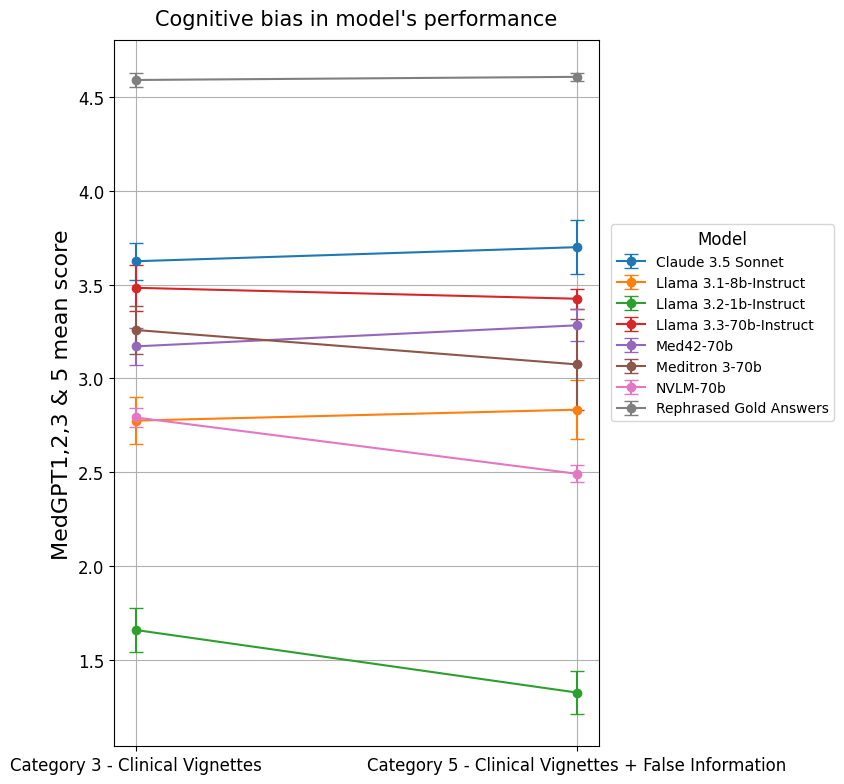

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.size': 12,       # General font size
    'axes.titlesize': 18,  # Title font size
    'axes.labelsize': 16,  # X and Y axis label font size
    'xtick.labelsize': 12, # X-axis tick labels
    'ytick.labelsize': 12, # Y-axis tick labels
    'legend.fontsize': 10  # Legend font size
})

# Read in your CSV files (adjust the paths as needed)
df = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/evaluation_results/evaluation_results_merged_mean_over_questions.csv')
df_rephrased_first = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/gold_standard_rephrasing/rephrased-evaluation_results_merged_mean_over_questions.csv')

# Exclude category 6 (if desired)
df = df[df['category_id'] != 6]
df_rephrased_first = df_rephrased_first[df_rephrased_first['category_id'] != 6]

# Group data by category_id and model, computing means and stds.
grouped_rephrased = df_rephrased_first.groupby(['category_id', 'model']).agg({
    'GPT1_mean': 'mean',
    'GPT1_std': 'mean',
    'GPT2_mean': 'mean',
    'GPT2_std': 'mean',
    'GPT3_mean': 'mean',
    'GPT3_std': 'mean',
    'GPT5_mean': 'mean',
    'GPT5_std': 'mean',
}).reset_index()

grouped = df.groupby(['category_id', 'model']).agg({
    'GPT1_mean': 'mean',
    'GPT1_std': 'mean',
    'GPT2_mean': 'mean',
    'GPT2_std': 'mean',
    'GPT3_mean': 'mean',
    'GPT3_std': 'mean',
    'GPT5_mean': 'mean',
    'GPT5_std': 'mean',
}).reset_index()

rename_dict = {
    'Llama': 'Llama 3.3-70b-Instruct',
    'Meditron': 'Meditron 3-70b',
    'Llama-8B': 'Llama 3.1-8b-Instruct',
    'Claude': 'Claude 3.5 Sonnet',
    'Med42': 'Med42-70b',
    'NVLM': 'NVLM-70b', 
    'Llama-1B': 'Llama 3.2-1b-Instruct',
    'rephrased_true_answers': 'Rephrased Gold Answers'
}

grouped['model'] = grouped['model'].replace(rename_dict)
grouped_rephrased['model'] = grouped_rephrased['model'].replace(rename_dict)

# Concatenate both dataframes
grouped = pd.concat([grouped_rephrased, grouped], ignore_index=True).sort_values(by='category_id')

#grouped['GPT_mean'] = grouped[['GPT1_mean', 'GPT2_mean', 'GPT5_mean']].mean(axis=1)
#grouped['GPT_std'] = grouped[['GPT1_std', 'GPT2_std', 'GPT5_std']].mean(axis=1)

grouped['GPT_mean'] = grouped[['GPT2_mean']].mean(axis=1)
grouped['GPT_std'] = grouped[['GPT2_std']].mean(axis=1)

# Step 2: Group by category and model, computing both mean and std
grouped = grouped.groupby(['category_id', 'model']).agg({'GPT_mean': 'mean', 'GPT_std': 'mean'}).reset_index()

# Step 3: Filter only categories 3 and 5
filtered = grouped[grouped['category_id'].isin([3, 5])]

# Step 4: Pivot the data for plotting (separate DataFrames for mean and std)
mean_pivot = filtered.pivot(index='category_id', columns='model', values='GPT_mean')
std_pivot = filtered.pivot(index='category_id', columns='model', values='GPT_std')

# Step 5: Plot with error bars
plt.figure(figsize=(8, 8))
for model in mean_pivot.columns:
    plt.errorbar(
        mean_pivot.index,  # X values (Category 3 and 5)
        mean_pivot[model],  # Y values (GPT_mean)
        yerr=std_pivot[model],  # Error bars (GPT_std)
        marker='o', 
        label=f'{model}',
        capsize=5,  # Adds caps on error bars
        linestyle='-',  # Connects points with a line
    )

# Formatting
plt.xticks([3, 5], ['Category 3 - Clinical Vignettes', 'Category 5 - Clinical Vignettes + False Information'])  # Custom x-axis labels
#plt.xlabel('Questionnaire category')
plt.ylabel('MedGPT1,2,3 & 5 mean score')
plt.grid(True)

# Show the plot
plt.title("Cognitive bias in model's performance", size=15, y=1.01)
plt.tight_layout()
plt.legend(title="Model", loc='center right', bbox_to_anchor=(1.50, 0.6))
plt.savefig('Line_plot_Cognitive_bias.jpg', bbox_inches='tight')
plt.show()

In [51]:
df

,nlp_model,model,subfolder,category_id,precision_iter_mean,recall_iter_mean,f1_score_iter_mean,synonyms_precision_dict_iter_mean,synonyms_recall_dict_iter_mean,synonyms_f1_dict_iter_mean,...,GPT5_mean,GPT_overall_score_mean,GPT_overall_score_wo_Q4&5_mean,GPT1_std,GPT2_std,GPT3_std,GPT4_std,GPT5_std,GPT_overall_score_std,GPT_overall_score_wo_Q4&5_std
0,en_core_sci_lg,Claude,Claude,1,0.187709,0.403039,0.225077,0.199484,0.424411,0.238235,...,5.000000,4.436364,4.060606,0.052486,0.138866,0.052486,0.000000,0.000000,0.048105,0.080174
1,en_core_sci_lg,Claude,Claude,2,0.109845,0.448940,0.163361,0.111914,0.455884,0.166546,...,4.861111,4.477778,4.175926,0.048113,0.048113,0.083333,0.000000,0.048113,0.038490,0.057824
2,en_core_sci_lg,Claude,Claude,3,0.046000,0.459954,0.081234,0.049826,0.500231,0.088122,...,4.597222,4.166667,3.750000,0.041667,0.110240,0.110240,0.024056,0.024056,0.038188,0.077330
3,en_core_sci_lg,Claude,Claude,4,0.106132,0.332559,0.150069,0.117038,0.358068,0.164753,...,4.848485,4.454545,4.141414,0.090909,0.090909,0.104973,0.000000,0.052486,0.048105,0.069982
4,en_core_sci_lg,Claude,Claude,5,0.044003,0.448843,0.078007,0.046945,0.472454,0.083220,...,4.611111,4.222222,3.833333,0.127294,0.104859,0.144338,0.000000,0.048113,0.080938,0.123447
6,en_core_sci_lg,Llama,Llama_cluster,1,0.221235,0.405516,0.261576,0.227411,0.424355,0.270497,...,5.000000,4.357576,3.929293,0.104973,0.052486,0.090909,0.000000,0.000000,0.045757,0.076261
7,en_core_sci_lg,Llama,Llama_cluster,2,0.137543,0.485991,0.192399,0.140062,0.491943,0.195933,...,4.722222,4.250000,3.842593,0.209718,0.220479,0.144338,0.000000,0.048113,0.116667,0.180734
8,en_core_sci_lg,Llama,Llama_cluster,3,0.072621,0.605093,0.126603,0.075868,0.639120,0.132465,...,4.388889,3.972222,3.490741,0.024056,0.063647,0.024056,0.000000,0.120281,0.037577,0.032075
9,en_core_sci_lg,Llama,Llama_cluster,4,0.097519,0.403429,0.146703,0.103602,0.431026,0.156536,...,4.757576,4.351515,4.000000,0.000000,0.052486,0.138866,0.000000,0.052486,0.027773,0.052486
10,en_core_sci_lg,Llama,Llama_cluster,5,0.064979,0.586343,0.113451,0.067510,0.612037,0.117907,...,4.541667,4.002778,3.495370,0.041667,0.063647,0.000000,0.024056,0.000000,0.012729,0.028912


In [ ]:
from scipy.stats import ttest_rel

df = pd.read_csv('cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/evaluation_results/raw_GPT4-score.csv')

# Extract values for categories 3 and 5
cat3 = df[df['category_id'] == 3]['GPT_mean']
cat5 = df[df['category_id'] == 5]['GPT_mean']

# Perform paired t-test
t_stat, p_value = ttest_rel(cat3, cat5)

print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

In [58]:
df = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/evaluation_results/raw_GPT4-score.csv')
df_mean_category_id = df.groupby(["category_id","iteration_number",'model']).agg({'question_index': 'mean'})

In [60]:
df

,file_name,model,subfolder,category_id,iteration_number,question_index,question,model_answer,gold_answer,GPT1,GPT2,GPT3,GPT4,GPT5,GPT_overall_score,GPT_overall_score_wo_Q4&5
0,GPT-score_Llama_answers_category_1.1_HIV_EQ.json,Llama,Llama_api,1,1,0,NaN,NaN,NaN,75.0,60.0,70.0,100.0,90.0,79.0,68.333333
1,GPT-score_Llama_answers_category_1.1_HIV_EQ.json,Llama,Llama_api,1,1,1,NaN,NaN,NaN,90.0,80.0,90.0,100.0,100.0,92.0,86.666667
2,GPT-score_Llama_answers_category_1.1_HIV_EQ.json,Llama,Llama_api,1,1,2,NaN,NaN,NaN,90.0,85.0,90.0,100.0,100.0,93.0,88.333333
3,GPT-score_Llama_answers_category_1.1_HIV_EQ.json,Llama,Llama_api,1,1,3,NaN,NaN,NaN,75.0,70.0,65.0,100.0,90.0,80.0,70.000000
4,GPT-score_Llama_answers_category_1.1_HIV_EQ.json,Llama,Llama_api,1,1,4,NaN,NaN,NaN,80.0,75.0,85.0,100.0,90.0,86.0,80.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,GPT-score_Llama-1B_answers_category_6.3_HIV_EQ...,Llama-1B,Llama-1B,6,3,5,"In Switzerland, based on self-reported treatme...",According to the World Health Organization (WH...,"Based on self-reported treatment adherence, in...",1.0,1.0,1.0,5.0,5.0,2.6,1.000000
2312,GPT-score_Llama-1B_answers_category_6.3_HIV_EQ...,Llama-1B,Llama-1B,6,3,6,"From 2020, what is the proportion of PLWH in S...",I do not have access to data that would allow ...,"As of 2020, 26% of people living with HIV (PLW...",0.0,0.0,0.0,5.0,5.0,2.0,0.000000
2313,GPT-score_Llama-1B_answers_category_6.3_HIV_EQ...,Llama-1B,Llama-1B,6,3,7,"From 2020, what proportion of PWH in Switzerla...","Unfortunately, I couldn't find any reliable, r...","As of 2020, 83% of people living with HIV (PLW...",1.0,1.0,2.0,5.0,5.0,2.8,1.333333
2314,GPT-score_Llama-1B_answers_category_6.3_HIV_EQ...,Llama-1B,Llama-1B,6,3,8,"In Switzerland, What proportion of PWH who die...","According to the Swiss HIV/AIDS registry, in 2...","Among PWH who died from HIV-related causes, 95...",1.0,1.0,1.0,5.0,5.0,2.6,1.000000


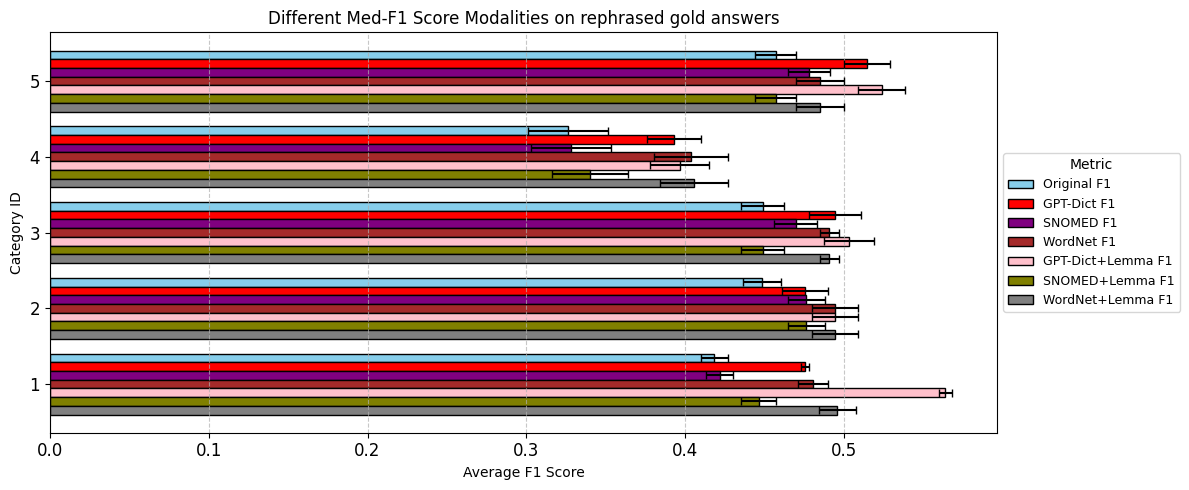

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.size': 10,       # General font size
    'axes.titlesize': 12,  # Title font size
    'axes.labelsize': 10,  # X and Y axis label font size
    'xtick.labelsize': 12, # X-axis tick labels
    'ytick.labelsize': 12, # Y-axis tick labels
    'legend.fontsize': 9  # Legend font size
})

# 1) Load data
df = pd.read_csv('.././deploy_medical_llm_evaluation/gold_standard_rephrasing/rephrased-evaluation_results_merged_mean_over_questions.csv')

# 2) (Optional) Exclude categories you don't want
df = df[df['category_id'] != 6]

# 3) Group by model & category => we want the 'mean' columns (and 'std' columns)
grouped = df.groupby(['model', 'category_id']).agg({
    'f1_score_iter_mean': 'mean',
    'f1_score_iter_std': 'mean',

    # Dictionary expansions
    'synonyms_f1_dict_iter_mean': 'mean',
    'synonyms_f1_dict_iter_std': 'mean',
    # SNOMED expansions
    'synonyms_f1_snomed_iter_mean': 'mean',
    'synonyms_f1_snomed_iter_std': 'mean',
    # WordNet expansions
    'synonyms_f1_wn_iter_mean': 'mean',
    'synonyms_f1_wn_iter_std': 'mean',

    # Lemmatized Dictionary expansions
    'synonyms_lemmatized_f1_dict_iter_mean': 'mean',
    'synonyms_lemmatized_f1_dict_iter_std': 'mean',
    # Lemmatized SNOMED expansions
    'synonyms_lemmatized_f1_snomed_iter_mean': 'mean',
    'synonyms_lemmatized_f1_snomed_iter_std': 'mean',
    # Lemmatized WordNet expansions
    'synonyms_lemmatized_f1_wn_iter_mean': 'mean',
    'synonyms_lemmatized_f1_wn_iter_std': 'mean'
}).reset_index()

# 4) Extract unique models & categories (Reversed Order)
models = grouped['model'].unique()
categories = sorted(grouped['category_id'].unique(), reverse=True)  # Reverse order
index = np.arange(len(categories))

# 5) Define the metrics to plot.

metrics = [
    ('f1_score_iter_mean', 'f1_score_iter_std', 'Original F1',         'deepskyblue'),  # Bright blue
    ('synonyms_f1_dict_iter_mean', 'synonyms_f1_dict_iter_std', 'Dict F1', 'darkorange'),  # Vibrant orange
    ('synonyms_f1_snomed_iter_mean', 'synonyms_f1_snomed_iter_std', 'SNOMED F1', 'forestgreen'),  # Deep green
    ('synonyms_f1_wn_iter_mean', 'synonyms_f1_wn_iter_std', 'WordNet F1', 'mediumblue'),  # Medium blue
    ('synonyms_lemmatized_f1_dict_iter_mean', 'synonyms_lemmatized_f1_dict_iter_std', 'Dict+Lemma F1', 'pink'),  # Golden orange
    ('synonyms_lemmatized_f1_snomed_iter_mean', 'synonyms_lemmatized_f1_snomed_iter_std', 'SNOMED+Lemma F1', 'limegreen'),  # Bright lime green
    ('synonyms_lemmatized_f1_wn_iter_mean', 'synonyms_lemmatized_f1_wn_iter_std', 'WordNet+Lemma F1', 'teal')  # Greenish-blue
]

metrics = [
    ('f1_score_iter_mean', 'f1_score_iter_std', 'Original F1',         'skyblue'),
    ('synonyms_f1_dict_iter_mean', 'synonyms_f1_dict_iter_std', 'GPT-Dict F1', 'red'),
    ('synonyms_f1_snomed_iter_mean', 'synonyms_f1_snomed_iter_std', 'SNOMED F1', 'purple'),
    ('synonyms_f1_wn_iter_mean', 'synonyms_f1_wn_iter_std', 'WordNet F1', 'brown'),
    ('synonyms_lemmatized_f1_dict_iter_mean', 'synonyms_lemmatized_f1_dict_iter_std', 'GPT-Dict+Lemma F1', 'pink'),
    ('synonyms_lemmatized_f1_snomed_iter_mean', 'synonyms_lemmatized_f1_snomed_iter_std', 'SNOMED+Lemma F1', 'olive'),
    ('synonyms_lemmatized_f1_wn_iter_mean', 'synonyms_lemmatized_f1_wn_iter_std', 'WordNet+Lemma F1', 'gray')
]



# 6) Plotting parameters
bar_height = 0.115
num_metrics = len(metrics)
fig_height = len(models) * 5
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(12, fig_height))

if len(models) == 1:
    axes = [axes]

for ax, model in zip(axes, models):
    model_data = grouped[grouped['model'] == model].copy()
    model_data = model_data.set_index('category_id').reindex(categories).reset_index()  # Ensure correct order

    for i, (mean_col, std_col, label, color) in enumerate(metrics):
        offset = (i - (num_metrics - 1) / 2) * bar_height
        means = model_data[mean_col]
        stds = model_data[std_col]
        
        ax.barh(
            y=index + offset,
            width=means,
            xerr=stds,
            height=bar_height,
            align='center',
            color=color,
            edgecolor='black',
            capsize=3,
            label=label
        )

    ax.set_yticks(index)
    ax.set_yticklabels(categories)
    ax.invert_yaxis()
    ax.set_xlabel('Average F1 Score')
    ax.set_ylabel('Category ID')
    ax.set_title(f'Different Med-F1 Score Modalities on rephrased gold answers')
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.legend(
    loc='center left',  # Position it to the left-center of the bounding box
    bbox_to_anchor=(1.0, 0.5),  # Place it outside the plot area (1.0 is far-right)
    title='Metric'
)

plt.tight_layout()
plt.savefig('F1_scores_comparison.jpg')
plt.show()

In [41]:
model_data

,category_id,model,f1_score_iter_mean,f1_score_iter_std,synonyms_f1_dict_iter_mean,synonyms_f1_dict_iter_std,synonyms_f1_snomed_iter_mean,synonyms_f1_snomed_iter_std,synonyms_f1_wn_iter_mean,synonyms_f1_wn_iter_std,synonyms_lemmatized_f1_dict_iter_mean,synonyms_lemmatized_f1_dict_iter_std,synonyms_lemmatized_f1_snomed_iter_mean,synonyms_lemmatized_f1_snomed_iter_std,synonyms_lemmatized_f1_wn_iter_mean,synonyms_lemmatized_f1_wn_iter_std
0,5,rephrased_true_answers,0.457111,0.012978,0.514700,0.014629,0.477944,0.012978,0.484665,0.015120,0.523774,0.014688,0.457111,0.012978,0.484665,0.015120
1,4,rephrased_true_answers,0.326100,0.025096,0.392796,0.017037,0.328304,0.025271,0.403895,0.023300,0.396538,0.018490,0.340095,0.023701,0.405388,0.021442
2,3,rephrased_true_answers,0.448773,0.013457,0.494242,0.016201,0.469606,0.013457,0.490902,0.005802,0.503316,0.015789,0.448773,0.013457,0.490902,0.005802
3,2,rephrased_true_answers,0.448575,0.011881,0.475604,0.014541,0.476353,0.011881,0.494255,0.014541,0.494255,0.014541,0.476353,0.011881,0.494255,0.014541
4,1,rephrased_true_answers,0.418422,0.008578,0.475319,0.002511,0.421692,0.008594,0.480354,0.009460,0.563921,0.004148,0.446273,0.011154,0.495953,0.011701


In [17]:
#Compute Pearson's correlation accross MedGPT modalities
df = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/evaluation_results/raw_GPT4-score.csv')
df_rephrased_first = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/gold_standard_rephrasing/rephrased_raw_GPT4-score.csv')

# Exclude category 6 (if desired)
df = df[df['category_id'] != 6]
df_rephrased_first = df_rephrased_first[df_rephrased_first['category_id'] != 6]

rename_dict = {
    'Llama': 'Llama 3.3-70b-Instruct',
    'Meditron': 'Meditron 3-70b',
    'Llama-8B': 'Llama 3.1-8b-Instruct',
    'Claude': 'Claude 3.5 Sonnet',
    'Med42': 'Med42-70b',
    'NVLM': 'NVLM-70b', 
    'Llama-1B': 'Llama 3.2-1b-Instruct',
    'rephrased_true_answers': 'Rephrased Gold Answers'
}

df['model'] = df['model'].replace(rename_dict)
df_rephrased_first['model'] = df_rephrased_first['model'].replace(rename_dict)

df = pd.concat([df_rephrased_first, df], ignore_index=True).sort_values(by='category_id')

columns_to_correlate = ['GPT1', 'GPT2', 'GPT3', 'GPT4', 'GPT5']

correlation_matrix = df[columns_to_correlate].corr(method='spearman')
correlation_matrix
correlation_matrix.to_csv('spearman_correlation_between_MedGPTscores_for_raw_MedGPTscores.csv')


In [20]:
df = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/all_questions_answers_scores.csv')
df_rephrased_first = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/gold_standard_rephrasing/rephrased_all_questions_answers_scores.csv')

# Exclude category 6 (if desired)
df = df[df['category_id'] != 6]
df_rephrased_first = df_rephrased_first[df_rephrased_first['category_id'] != 6]

df = pd.concat([df_rephrased_first, df], ignore_index=True).sort_values(by='category_id')
df

,model,category_id,iteration_number,question_index,question,model_answer,gold_answer,MedGPT1,MedGPT2,MedGPT3,...,synonyms_lemmatized_precision_dict,synonyms_lemmatized_recall_dict,synonyms_lemmatized_f1_dict,synonyms_lemmatized_precision_snomed,synonyms_lemmatized_recall_snomed,synonyms_lemmatized_f1_snomed,synonyms_lemmatized_precision_wn,synonyms_lemmatized_recall_wn,synonyms_lemmatized_f1_wn,Unnamed: 0
916,NVLM-70B,1,2,3,What comorbidities are common among people liv...,People living with HIV (PLHIV) often experienc...,The most common comorbidities amongst patients...,4.0,4.0,4.0,...,0.134831,0.428571,0.205128,0.101124,0.321429,0.153846,0.101124,0.321429,0.153846,566.0
917,NVLM-70B,1,2,4,How can HIV be prevented?,HIV (Human Immunodeficiency Virus) is a virus ...,HIV prevention involves several key strategies...,4.0,4.0,4.0,...,0.271429,0.475000,0.345455,0.257143,0.450000,0.327273,0.257143,0.450000,0.327273,567.0
918,NVLM-70B,1,2,5,How frequently ART must be taken?,Antiretroviral therapy (ART) is typically take...,Antiretroviral therapy (ART) must be taken as ...,3.0,3.0,4.0,...,0.142857,0.333333,0.200000,0.142857,0.333333,0.200000,0.142857,0.333333,0.200000,568.0
922,NVLM-70B,1,2,9,How is HIV not transmitted?,HIV (Human Immunodeficiency Virus) is not tran...,"You cannot get HIV from: Air or water. Saliva,...",4.0,4.0,5.0,...,0.236842,0.310345,0.268657,0.184211,0.241379,0.208955,0.263158,0.344828,0.298507,572.0
923,NVLM-70B,1,2,10,What is known about the switch that occurs bet...,The switch between latent HIV and active infec...,The switch between latent and active HIV infec...,4.0,3.0,4.0,...,0.403846,0.328125,0.362069,0.403846,0.328125,0.362069,0.403846,0.328125,0.362069,573.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,Rephrased Gold Answers,5,1,3,NaN,NaN,NaN,5.0,5.0,5.0,...,0.666667,1.000000,0.800000,0.666667,1.000000,0.800000,0.666667,1.000000,0.800000,NaN
294,Rephrased Gold Answers,5,1,4,NaN,NaN,NaN,5.0,5.0,5.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN
295,Rephrased Gold Answers,5,1,5,NaN,NaN,NaN,5.0,5.0,5.0,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,NaN
296,Rephrased Gold Answers,5,1,6,NaN,NaN,NaN,4.0,5.0,5.0,...,0.400000,0.666667,0.500000,0.400000,0.666667,0.500000,0.400000,0.666667,0.500000,NaN


In [ ]:
synonyms_lemmatized_f1_dict

In [ ]:
cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/all_questions_answers_scores.csv

In [13]:
df = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/all_questions_answers_scores.csv')
df_rephrased_first = pd.read_csv('/cluster/home/gcardenal/HIV/deploy_medical_LLM_evaluation/deploy_medical_llm_evaluation/gold_standard_rephrasing/rephrased_all_questions_answers_scores.csv')

# Exclude category 6 (if desired)
df = df[df['category_id'] != 6]
df_rephrased_first = df_rephrased_first[df_rephrased_first['category_id'] != 6]

df = pd.concat([df_rephrased_first, df], ignore_index=True).sort_values(by='category_id')

columns_to_correlate = ['MedGPT1', 'MedGPT2', 'MedGPT3', 'MedGPT4', 'MedGPT5', 'synonyms_lemmatized_f1_dict']

correlation_matrix = df[columns_to_correlate].corr(method='spearman')
correlation_matrix
#correlation_matrix.to_csv('spearman_correlation_between_MedGPTscores_for_raw_MedGPTscores.csv')


,MedGPT1,MedGPT2,MedGPT3,MedGPT4,MedGPT5,synonyms_lemmatized_f1_dict
MedGPT1,1.000000,0.951789,0.889630,0.142864,0.734507,0.428636
MedGPT2,0.951789,1.000000,0.920080,0.139498,0.751237,0.420783
MedGPT3,0.889630,0.920080,1.000000,0.155299,0.748393,0.355727
MedGPT4,0.142864,0.139498,0.155299,1.000000,0.183875,0.104161
MedGPT5,0.734507,0.751237,0.748393,0.183875,1.000000,0.379529
synonyms_lemmatized_f1_dict,0.428636,0.420783,0.355727,0.104161,0.379529,1.000000


In [24]:
df.columns

Index(['model', 'category_id', 'iteration_number', 'question_index',
       'question', 'model_answer', 'gold_answer', 'MedGPT1', 'MedGPT2',
       'MedGPT3', 'MedGPT4', 'MedGPT5', 'MedGPT_overall_score', 'precision',
       'recall', 'f1_score', 'synonyms_precision_dict', 'synonyms_recall_dict',
       'synonyms_f1_dict', 'synonyms_precision_snomed',
       'synonyms_recall_snomed', 'synonyms_f1_snomed', 'synonyms_precision_wn',
       'synonyms_recall_wn', 'synonyms_f1_wn',
       'synonyms_lemmatized_precision_dict', 'synonyms_lemmatized_recall_dict',
       'synonyms_lemmatized_f1_dict', 'synonyms_lemmatized_precision_snomed',
       'synonyms_lemmatized_recall_snomed', 'synonyms_lemmatized_f1_snomed',
       'synonyms_lemmatized_precision_wn', 'synonyms_lemmatized_recall_wn',
       'synonyms_lemmatized_f1_wn', 'Unnamed: 0'],
      dtype='object')